# GenomicSEM for combining GWAS Summary stats
Steps:
1. Munge summary statistics (if necessary from LDSC formatted data)
1. Compute covariance between traits using multivariate LDSC functionality from GenomicSEM 
1. Exploratory factor analysis to learn "appropriate" number of factors to explain all neuropsychiatric trait GWAS
1. Confirmatory factor analysis using GenomicSEM
1. Common factor GWAS with learned hierarchical model

In [1]:
library(data.table)
suppressPackageStartupMessages(library(tidyverse))
library(parallel)
suppressWarnings(library(GenomicSEM))
library(cowplot)
suppressPackageStartupMessages(library(glue))

## Munge Summary statistics


In [2]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/adhd_jul2017.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/anxiety.meta.full.fs.tbl.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/anxiety.meta.full.cc.tbl.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pgcAN2.2019-07_refmt.vcf.tsv.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/AUDIT_UKB_2018_AJP_fixed.txt.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/Cannabis_ICC_23andmetop_UKB_het_fixed.txt.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/iPSYCH-PGC_ASD_Nov2017.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/ocd_aug2017.gz",
    # "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pgc_alcdep.trans_fe_unrel_geno.aug2018_release.txt.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pgc_alcdep.eur_unrelated.aug2018_release_refmt.txt.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pgc_bip_2018.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/PGC_UKB_depression_genome-wide_fixed.txt.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/MDD2018_ex23andMe.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/PGC3_SCZ_wave3_public.v2.tsv.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/tag.cpd.tbl.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/TS_Oct2018.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pts_all_freeze2_overall.results.gz",
)
sample_sizes < -c(
    55374,
    17310,
    17310,
    72517,
    141932,
    184765,
    46351,
    9725,
    38686,
    198882,
    500199,
    173005,
    161405,
    74053,
    14307,
    64357,
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    0.36,
    NA,
    0.33,
    0.23,
    NA,
    0.30,
    0.40,
    0.28,
    0.26,
    0.15,
    0.34,
    0.35,
    0.42,
    NA,
    0.34,
    0.15,
)  # Sample prevalence
population_prev < -c(
    0.094,
    NA,
    0.19,
    0.006,
    NA,
    0.16,
    0.019,
    0.012,
    0.053,
    0.028,
    0.071,
    0.071,
    0.0075,
    NA,
    0.0089,
    0.068,
)  # Population prevalence
# length(sample_sizes)
# length(trait_names)
# length(sample_prev)
# length(population_prev)
traits < -paste0(trait_names, ".sumstats.gz")
# mclapply(1:length(sumstat_files),function(i)munge(sumstat_files[i],hm3 = "/scratch/st-dennisjk-1/wcasazza/w_hm3.snplist",N=sample_sizes[i],trait.names = trait_names[i]),mc.cores=16)
# i <- 8
# munge(sumstat_files[i],hm3 = "/scratch/st-dennisjk-1/wcasazza/w_hm3.snplist",N=sample_sizes[i],trait.names = trait_names[i])

## Compute covariances using multivariate LDSC
Combined vs sex-biased.

In [14]:
ld <- "/scratch/st-dennisjk-1/wcasazza/1000G_Phase3_weights_hm3_no_MHC"#non-partitioned ldscores dir
wld <- "/scratch/st-dennisjk-1/wcasazza/1000G_Phase3_weights_hm3_no_MHC"#unweighted ld scores dir, in tutorial is the same as above
LDSCoutput <- ldsc(traits=traits, sample.prev=sample_prev, population.prev=population_prev, ld=ld, wld=wld, trait.names=trait_names)

[1] "Multivariate ld-score regression of 16 traits (ADHD.sumstats.gz ANXFS.sumstats.gz ANX.sumstats.gz AN.sumstats.gz AUDIT.sumstats.gz CUD.sumstats.gz ASD.sumstats.gz OCD.sumstats.gz ALC.sumstats.gz BIP.sumstats.gz MDD.sumstats.gz MDD2018.sumstats.gz SCZ.sumstats.gz TAG_CPD.sumstats.gz TS.sumstats.gz PTSD.sumstats.gz) began at: 2021-09-27 15:51:48"
[1] "Reading in LD scores"
[1] "Read in summary statistics [1/16] from: ADHD.sumstats.gz"
[1] "Out of 1069649 SNPs, 1061550 remain after merging with LD-score files"
[1] "Removing 0 SNPs with Chi^2 > 80; 1061550 remain"
[1] "Read in summary statistics [2/16] from: ANXFS.sumstats.gz"
[1] "Out of 1101487 SNPs, 1086988 remain after merging with LD-score files"
[1] "Removing 0 SNPs with Chi^2 > 80; 1086988 remain"
[1] "Read in summary statistics [3/16] from: ANX.sumstats.gz"
[1] "Out of 1102788 SNPs, 1088269 remain after merging with LD-score files"
[1] "Removing 0 SNPs with Chi^2 > 80; 1088269 remain"
[1] "Read in summary statistics [4/16] fro

List of 5
 $ V: num [1:136, 1:136] 8.93e-03 4.31e-04 1.78e-05 1.33e-04 2.37e-04 ...
 $ S: num [1:16, 1:16] 1.44092 0.19395 0.29163 -0.00737 0.02979 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:16] "ADHD" "ANXFS" "ANX" "AN" ...
 $ I: num [1:16, 1:16] 1.03191 -0.00123 0.00378 0.12674 0.00619 ...
 $ N: num [1, 1:136] 55374 30632 29383 62993 81731 ...
 $ m: num 5961159


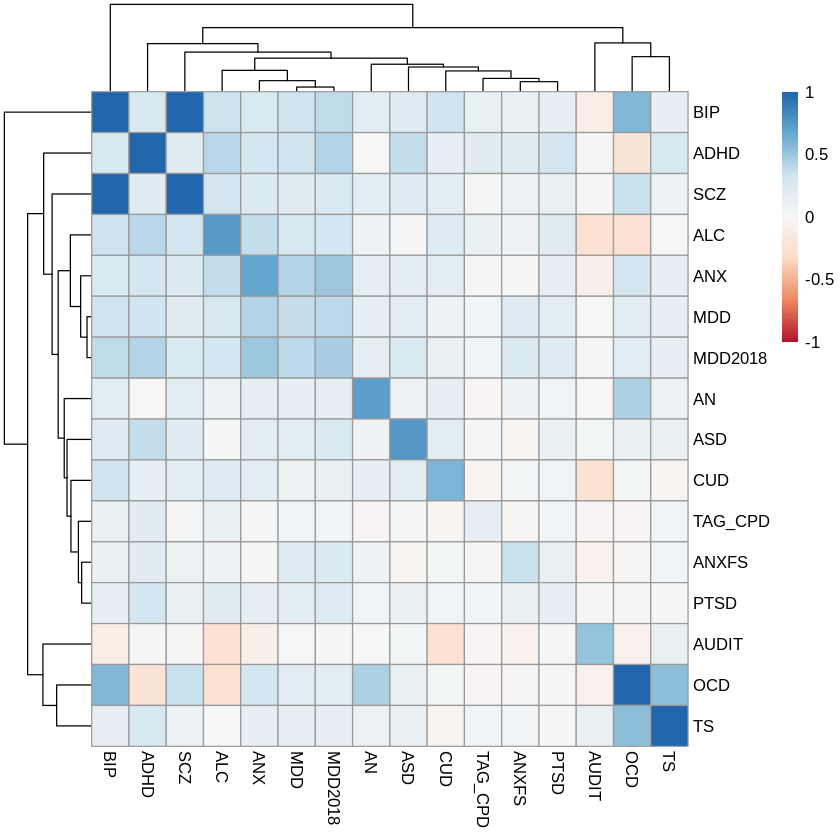

ADHD,ALC,AN,ANXFS,ASD,BIP,MDD2018,OCD,PTSD,SCZ,TS
1.0000,0.3920,-0.0072,0.2718,0.3643,0.1339,0.5285,-0.1552,0.6866,0.1598,0.2075
0.3920,1.0000,0.1106,0.1476,0.0284,0.2429,0.5230,-0.2529,0.6207,0.3523,0.0170
-0.0072,0.1106,1.0000,0.1519,0.1000,0.1268,0.2952,0.4597,0.2120,0.2078,0.1052
0.2718,0.1476,0.1519,1.0000,-0.0875,0.1048,0.5920,-0.0171,0.5809,0.1668,0.0674
0.3643,0.0284,0.1000,-0.0875,1.0000,0.1435,0.4127,0.1196,0.3342,0.2440,0.1244
0.1339,0.2429,0.1268,0.1048,0.1435,1.0000,0.3379,0.3042,0.2323,0.6708,0.0713
0.5285,0.5230,0.2952,0.5920,0.4127,0.3379,1.0000,0.2307,0.8290,0.3750,0.1770
-0.1552,-0.2529,0.4597,-0.0171,0.1196,0.3042,0.2307,1.0000,0.0682,0.3056,0.4244
0.6866,0.6207,0.2120,0.5809,0.3342,0.2323,0.8290,0.0682,1.0000,0.3181,-0.0352
0.1598,0.3523,0.2078,0.1668,0.2440,0.6708,0.3750,0.3056,0.3181,1.0000,0.0823


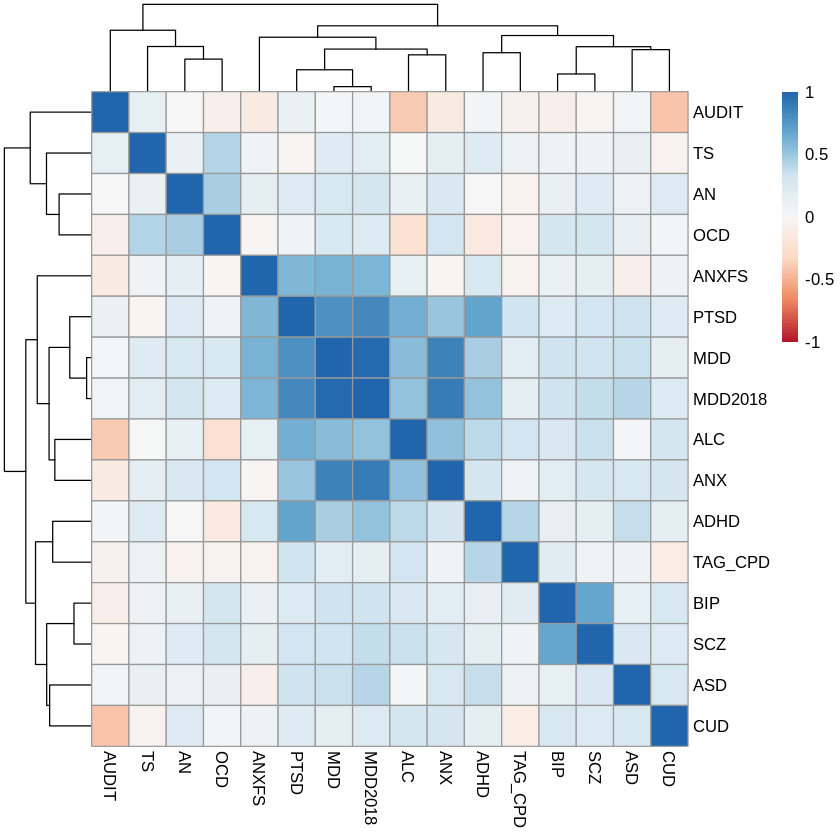

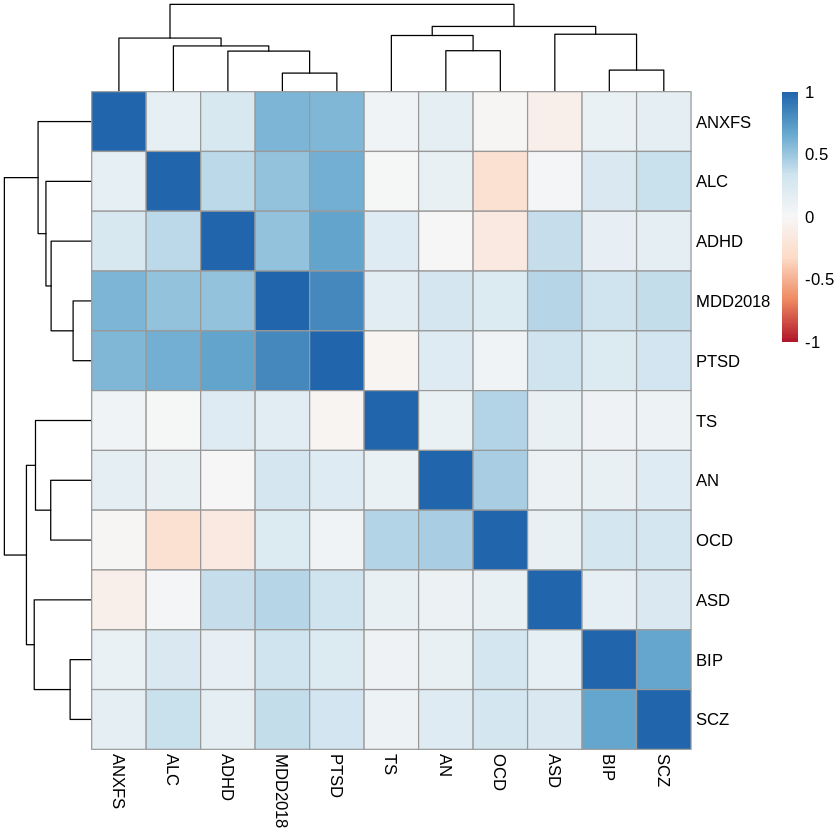

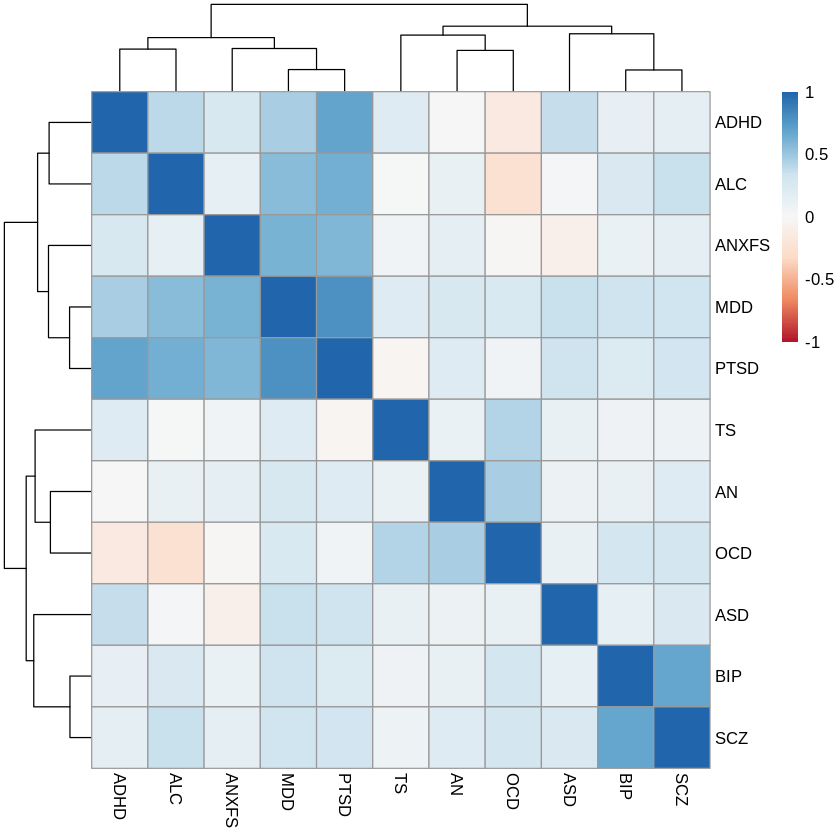

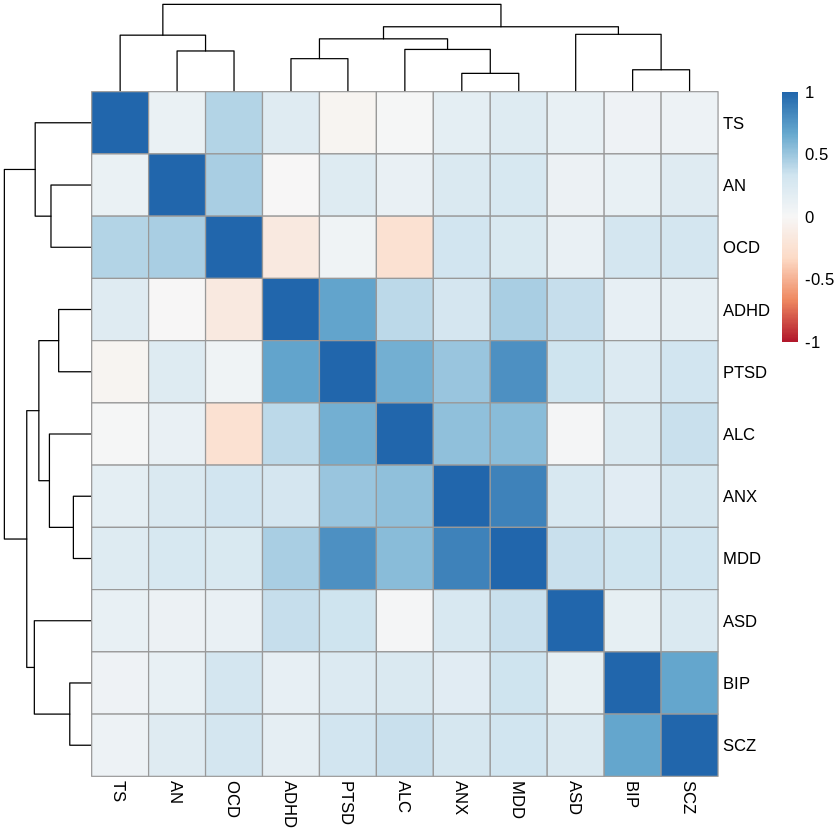

In [3]:
library(pheatmap)
library(RColorBrewer)
if(!file.exists("../data/LDSC_covariances_EUR.RDS")){
    saveRDS(LDSCoutput,"../data/LDSC_covariances_EUR.RDS")
}else{
    LDSCoutput <- readRDS("../data/LDSC_covariances_EUR.RDS")
}
str(LDSCoutput)
if(!file.exists("../data/genetic_correlation_EUR_genomicSEM.txt")){
    tmp_cor <- fread("grep  'Genetic Correlation between' ADHD.sumstats.gz_ANXFS.sumstats.gz_ANX.sumstats.gz_AN.sumstats.gz_AUDIT.sumstats.gz_CUD.sumstats.gz__ldsc.log")
    tmp_cor <- tmp_cor[,.(Trait1=V4,Trait2=gsub(":","",V6),R=V7,SE=as.numeric(gsub("\\(|\\)","",V8)))]
    tmp_cor <- rbind(tmp_cor,data.table(Trait1 = trait_names,Trait2 = trait_names,R=1,SE=0))
    print(tmp_cor[Trait1 == "AN" | Trait2 == "AN"])
    tmp_cor <- dcast(tmp_cor,Trait1~Trait2,value.var="R")
    tmp_cor <- as.matrix(tmp_cor[,-c(1)])
    tmp_cor[is.na(tmp_cor)] <- 0
    upper <- upper.tri(tmp_cor)
    lower <- lower.tri(tmp_cor)
    cor_to_plot <- matrix(0,nrow=nrow(tmp_cor),ncol=ncol(tmp_cor))
    cor_to_plot[upper] <- tmp_cor[upper] + t(tmp_cor)[upper]
    cor_to_plot <- t(cor_to_plot)
    cor_to_plot[upper] <- tmp_cor[upper] + t(tmp_cor)[upper]
    print(cor_to_plot)
    diag(cor_to_plot) <- 1
    rownames(cor_to_plot) <- colnames(cor_to_plot) <- colnames(tmp_cor)
    cor_to_plot
    fwrite(melt(cor_to_plot),"../data/genetic_correlation_EUR_genomicSEM.txt")
}
cov_to_plot <- LDSCoutput$S
rownames(cov_to_plot) <- colnames(LDSCoutput$S)

genetic_corr <- fread("../data/genetic_correlation_EUR_genomicSEM.txt")
cor_to_plot <- as.matrix(dcast(genetic_corr,Var1~Var2)[,-c(1)])
rownames(cor_to_plot) <- colnames(cor_to_plot)
pheatmap(cov_to_plot,color = colorRampPalette(brewer.pal(n = 7, name = "RdBu"))(200),breaks = seq(-1,1,0.01))
pheatmap(cor_to_plot,color = colorRampPalette(brewer.pal(n = 7, name = "RdBu"))(200),breaks = seq(-1,1,0.01))
eleven_traits <- c("ADHD","AN", "ANXFS", "ALC","ASD","OCD","BIP","MDD2018","SCZ","TS","PTSD")
cor_to_plot <- as.matrix(dcast(genetic_corr %>% filter(Var1 %in%eleven_traits, Var2 %in% eleven_traits),Var1~Var2)[,-c(1)])
cor_to_plot
rownames(cor_to_plot) <- colnames(cor_to_plot)
pheatmap(cor_to_plot, color = colorRampPalette(brewer.pal(n = 7, name = "RdBu"))(200),breaks = seq(-1,1,0.01))

eleven_traits <- c("ADHD","AN", "ANXFS", "ALC","ASD","OCD","BIP","MDD","SCZ","TS","PTSD")
cor_to_plot <- as.matrix(dcast(genetic_corr %>% filter(Var1 %in%eleven_traits, Var2 %in% eleven_traits),Var1~Var2)[,-c(1)])
rownames(cor_to_plot) <- colnames(cor_to_plot)
pheatmap(cor_to_plot,color = colorRampPalette(brewer.pal(n = 7, name = "RdBu"))(200),breaks = seq(-1,1,0.01)) 
eleven_traits <- c("ADHD","AN", "ANX", "ALC","ASD","OCD","BIP","MDD","SCZ","TS","PTSD")
cor_to_plot <- as.matrix(dcast(genetic_corr %>% filter(Var1 %in%eleven_traits, Var2 %in% eleven_traits),Var1~Var2)[,-c(1)])
rownames(cor_to_plot) <- colnames(cor_to_plot)
pheatmap(cor_to_plot,color = colorRampPalette(brewer.pal(n = 7, name = "RdBu"))(200),breaks = seq(-1,1,0.01)) 

## Common factor GWAS

In [4]:
se_logit <- c(
    T,
    T,
    T,
    F,
    T,
    T,
    T,
    T,
    T,
    T,
    T,
    F,
    T,
    T,
    T
)

ols <- c(
    F,
    F,
    F,
    T,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    T,
    F,
    F,
    F
)
linprob <- c(
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    T
)

p_sumstats <-sumstats(
    files=sumstat_files,
    ref="../../reference.1000G.maf.0.005.txt",
    trait.names=trait_names,
    se.logit=se_logit,
    OLS=ols,
    linprob=linprob,
    prop=sample_prev,
    N=sample_sizes,
    info.filter=0.6,
    maf.filter=0.01,
    keep.indel=FALSE,
    parallel=T,
    cores=16)

In [4]:
if(!file.exists("common_factor_sumstats_15_traits.txt.gz")){
    fwrite(p_sumstats,"common_factor_sumstats_15_traits.txt.gz",sep='\t',quote=F,row.names=F)
}else{
    p_sumstats <- fread("common_factor_sumstats_15_traits.txt.gz")
}
head(p_sumstats)

## Common factor GWAS

In [ ]:
pfactor < -commonfactorGWAS(covstruc=LDSCoutput, SNPs=p_sumstats)

This is lavaan 0.6-8
lavaan is FREE software! Please report any bugs.



##  Stratified LDSC
@TODO Rename stratified LDSC files below to baseline versions and most recent heritability filtered and check baseline format/annotation ordering

In [ ]:
s_ld <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/sex_interaction_bin_CPP_her"
baseline <- "/scratch/st-dennisjk-1/wcasazza/1000G_v2.2_baseline/baselineLD"
frq <- "/scratch/st-dennisjk-1/wcasazza/1000G_Phase3_frq/1000G.EUR.QC"
wld <- "/scratch/st-dennisjk-1/wcasazza/weights_hm3_no_hla/weights"

SLDSCoutput_sex_interaction <- s_ldsc(traits=traits, sample.prev=sample_prev, population.prev=population_prev, ld=c(baseline,s_ld), wld=wld, frq=frq,trait.names=trait_names)
saveRDS(SLDSCoutput_sex_interaction,"SLDSCoutput_sex_interaction_her.RDS")

In [ ]:
s_ld <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/marginal_bin_CPP_her"
SLDSCoutput_marginal <- s_ldsc(traits=traits, sample.prev=sample_prev, population.prev=population_prev, ld=c(baseline, s_ld), wld=wld, frq=frq,trait.names=trait_names)
saveRDS(SLDSCoutput_marginal,"SLDSCoutput_marginal_her.RDS")

In [ ]:
s_ld <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/cord_mqtl_bin_CPP_her"
SLDSCoutput_marginal <- s_ldsc(traits=traits, sample.prev=sample_prev, population.prev=population_prev, ld=c(baseline, s_ld), wld=wld, frq=frq,trait.names=trait_names)
saveRDS(SLDSCoutput_marginal,"SLDSCoutput_cord_mqtl_her.RDS")

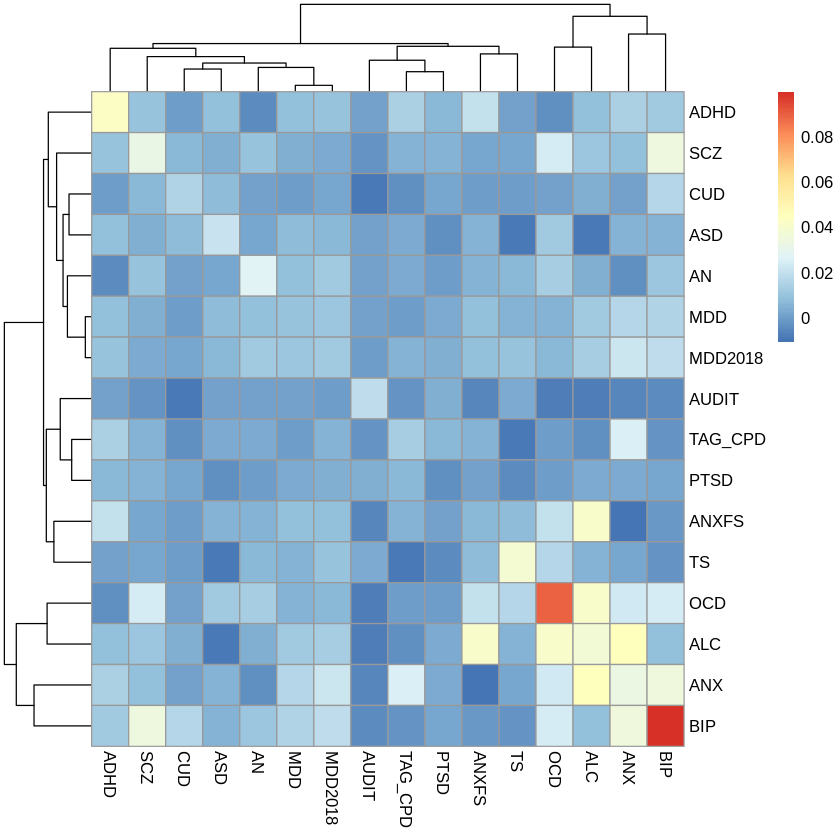

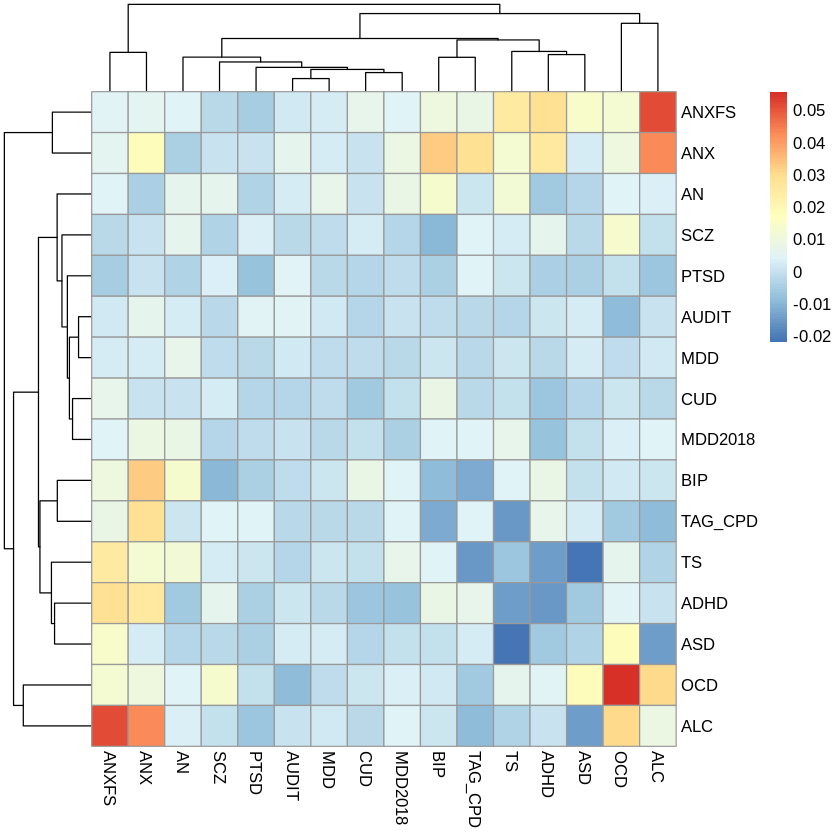

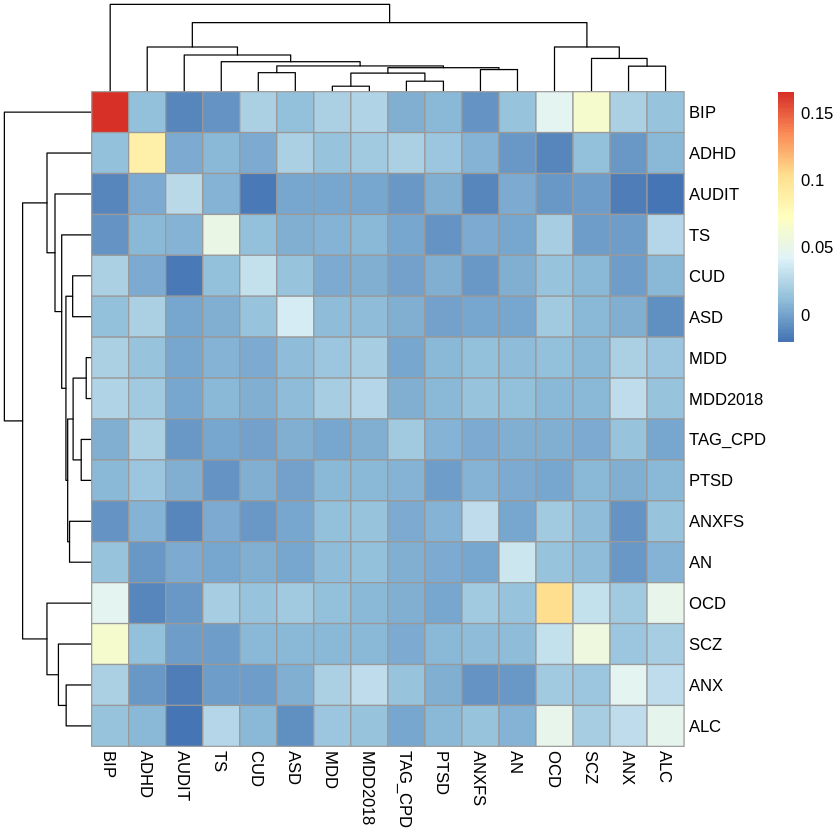

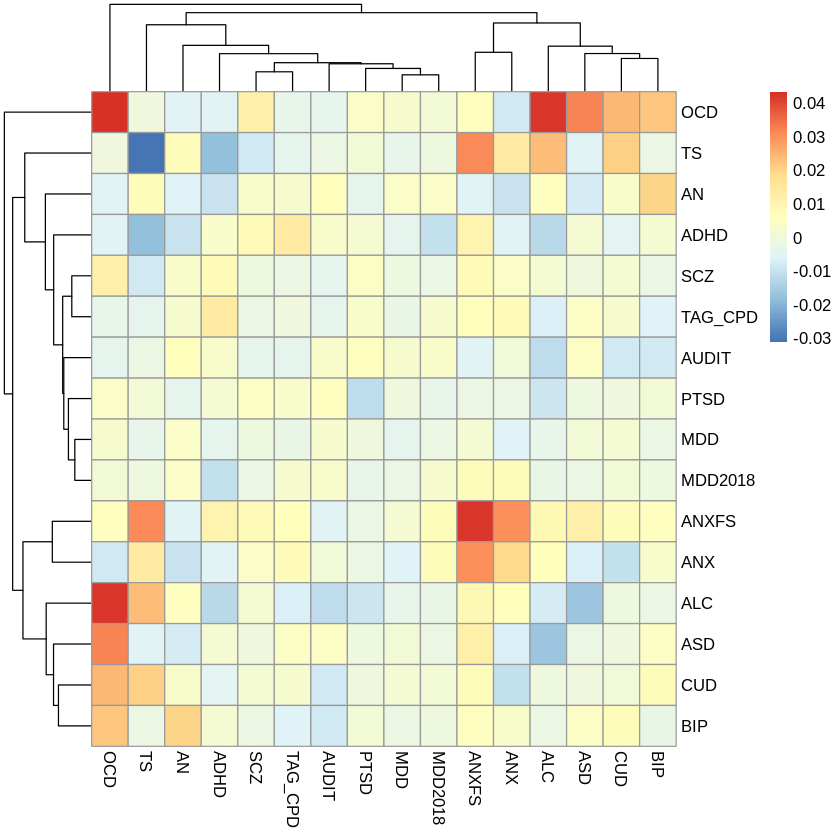

In [3]:
library(pheatmap)
SLDSCoutput_sex_interaction <- readRDS("../data/SLDSCoutput_sex_interaction_bin_CPP_her.RDS")
SLDSCoutput_marginal <- readRDS("../data/SLDSCoutput_marginal_bin_CPP_her.RDS")
tmp_cov <- SLDSCoutput_sex_interaction$S$`/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/sex_interaction_bin_CPP_her`
rownames(tmp_cov) <- colnames(tmp_cov)
pheatmap(tmp_cov)

tmp_cov <- SLDSCoutput_sex_interaction$S_Tau$`/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/sex_interaction_bin_CPP_her`
rownames(tmp_cov) <- colnames(tmp_cov)
pheatmap(tmp_cov)


tmp_cov <- SLDSCoutput_marginal$S$`/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/marginal_bin_CPP_her`
rownames(tmp_cov) <- colnames(tmp_cov)
pheatmap(tmp_cov)

tmp_cov <- SLDSCoutput_marginal$S_Tau$`/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/marginal_bin_CPP_her`
rownames(tmp_cov) <- colnames(tmp_cov)
pheatmap(tmp_cov)

In [4]:
model <- "F1=~ADHD+ANXFS+AN+AUDIT+CUD+ASD+OCD+ALC+BIP+MDD+SCZ+TAG_CPD+TS+PTSD"
hierarchical_model <- "P=~F1+F2+F3+F4
F1=~AN+OCD+TS
F2=~SCZ+BIP+ALC
F3=~TS+ALC+ADHD+ASD+PTSD+MDD
F4=~ALC+PTSD+MDD+ANXFS
F1~~F1
F2~~F2
F3~~F3
F4~~F4
AN~~a*AN
a > 0.01
OCD~~b*OCD
b > 0.01
TS~~c*TS
c > 0.01
SCZ~~d*SCZ
d > 0.001
BIP~~e*BIP
e > 0.01
ALC~~f*ALC
f > 0.01
ADHD~~g*ADHD
g > 0.01
ASD~~h*ASD
h > 0.01
PTSD~~i*PTSD
i > 0.01
MDD~~j*MDD
j > 0.01
ANXFS~~k*ANXFS
k > 0.01
"
hierarchical_model_anx <- "P=~F1+F2+F3+F4
F1=~AN+OCD+TS
F2=~SCZ+BIP+ALC
F3=~TS+ALC+ADHD+ASD+PTSD+MDD
F4=~ALC+PTSD+MDD+ANX
F1~~F1
F2~~F2
F3~~F3
F4~~F4
AN~~a*AN
a > 0.01
OCD~~b*OCD
b > 0.01
TS~~c*TS
c > 0.01
SCZ~~d*SCZ
d > 0.01
BIP~~e*BIP
e > 0.01
ALC~~f*ALC
f > 0.01
ADHD~~g*ADHD
g > 0.01
ASD~~h*ASD
h > 0.01
PTSD~~i*PTSD
i > 0.01
MDD~~j*MDD
j > 0.01
ANX~~k*ANX
k > 0.01
"
params <- c("F1~~F1","F2~~F2","F3~~F3","F4~~F4","P~~P")

std.lv <- TRUE
s_covstruc <- SLDSCoutput_sex_interaction
enrich_sex_interaction <- enrich(s_covstruc = s_covstruc,model = hierarchical_model,params=params,std.lv = std.lv)
enrich_sex_interaction_anx <- enrich(s_covstruc = s_covstruc,model = hierarchical_model_anx,params=params,std.lv = std.lv)

s_covstruc <- SLDSCoutput_marginal
enrich_marginal<- enrich(s_covstruc = s_covstruc,model = hierarchical_model,params=params,std.lv = std.lv)
enrich_marginal_anx<- enrich(s_covstruc = s_covstruc,model = hierarchical_model_anx,params=params,std.lv = std.lv)

[1] "baseL2 is assumed to be the baseline annotation that includes all SNPs."
[1] "Running model for baseline annotation"
[1] "Confirming fixed model reproduces estimate from freely estimated model for baseline annotation."
[1] "Beginning estimation of enrichment for 98 functional annotations."
[1] "46 annotations were removed from the output because they were either continuous or flanking window annotatoins."
[1] "baseL2 is assumed to be the baseline annotation that includes all SNPs."
[1] "Running model for baseline annotation"
[1] "Confirming fixed model reproduces estimate from freely estimated model for baseline annotation."
[1] "Beginning estimation of enrichment for 98 functional annotations."
[1] "46 annotations were removed from the output because they were either continuous or flanking window annotatoins."
[1] "baseL2 is assumed to be the baseline annotation that includes all SNPs."
[1] "Running model for baseline annotation"
[1] "Confirming fixed model reproduces estimate fr

In [9]:
print(str(enrich_marginal_anx))

List of 6
 $ :'data.frame':	52 obs. of  11 variables:
  ..$ Annotation        : chr [1:52] "baseL2" "Coding_UCSCL2" "Conserved_LindbladTohL2" "CTCF_HoffmanL2" ...
  ..$ lhs               : chr [1:52] "F1" "F1" "F1" "F1" ...
  ..$ op                : chr [1:52] "~~" "~~" "~~" "~~" ...
  ..$ rhs               : chr [1:52] "F1" "F1" "F1" "F1" ...
  ..$ Cov_Smooth        : num [1:52] 0.0111 0.0215 0.0478 0.0486 0.0482 ...
  ..$ Z_smooth          : num [1:52] 3.2 1.35 1.82 2.6 2.12 ...
  ..$ Enrichment        : num [1:52] 1 1.386 -5.899 23.319 0.105 ...
  ..$ Enrichment_SE     : num [1:52] 0.728 17.927 18.491 16.865 7.266 ...
  ..$ Enrichment_p_value: num [1:52] 0.5 0.4914 0.6455 0.0928 0.549 ...
  ..$ Error             : num [1:52] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ Warning           : chr [1:52] "0" "lavaan WARNING: some estimated lv variances are negative" "lavaan WARNING: some estimated lv variances are negative" "lavaan WARNING: some estimated lv variances are negative" ...
 $ :'data.frame'

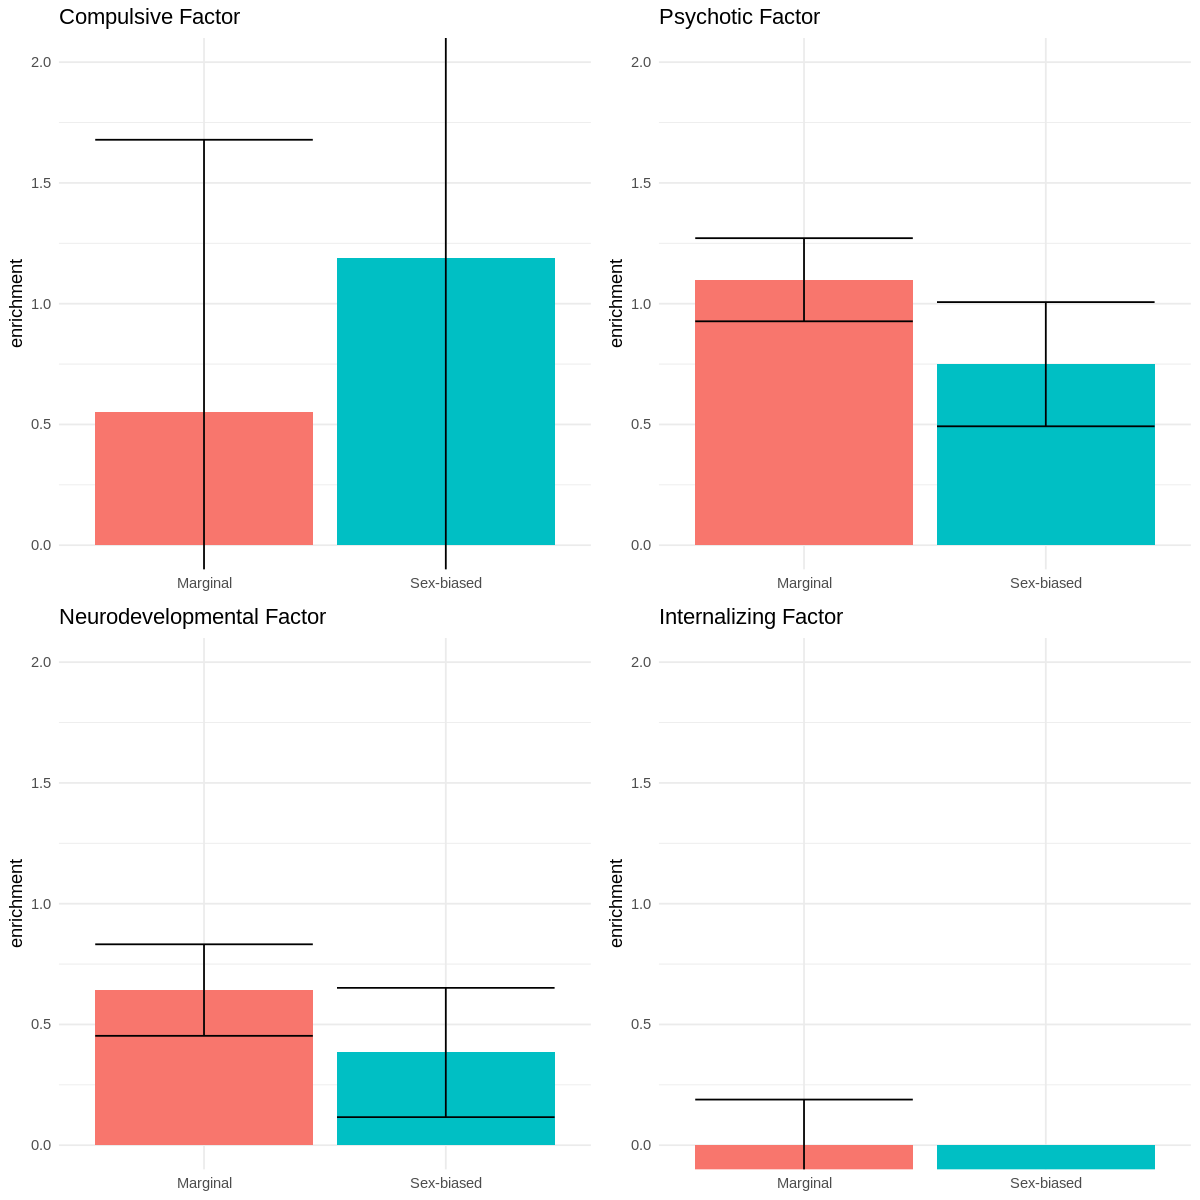

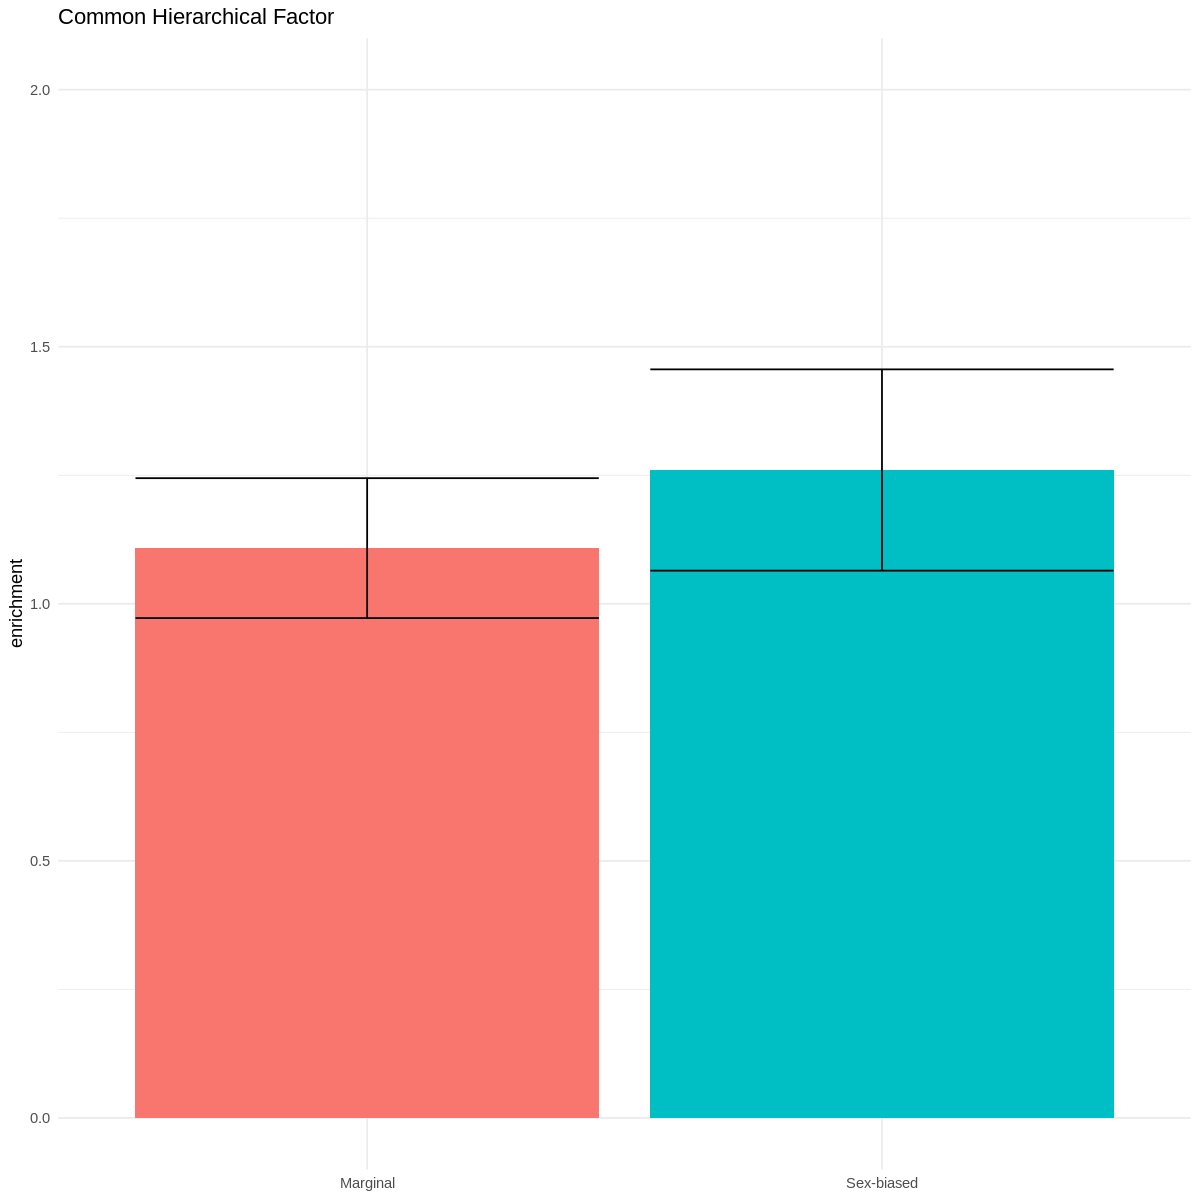

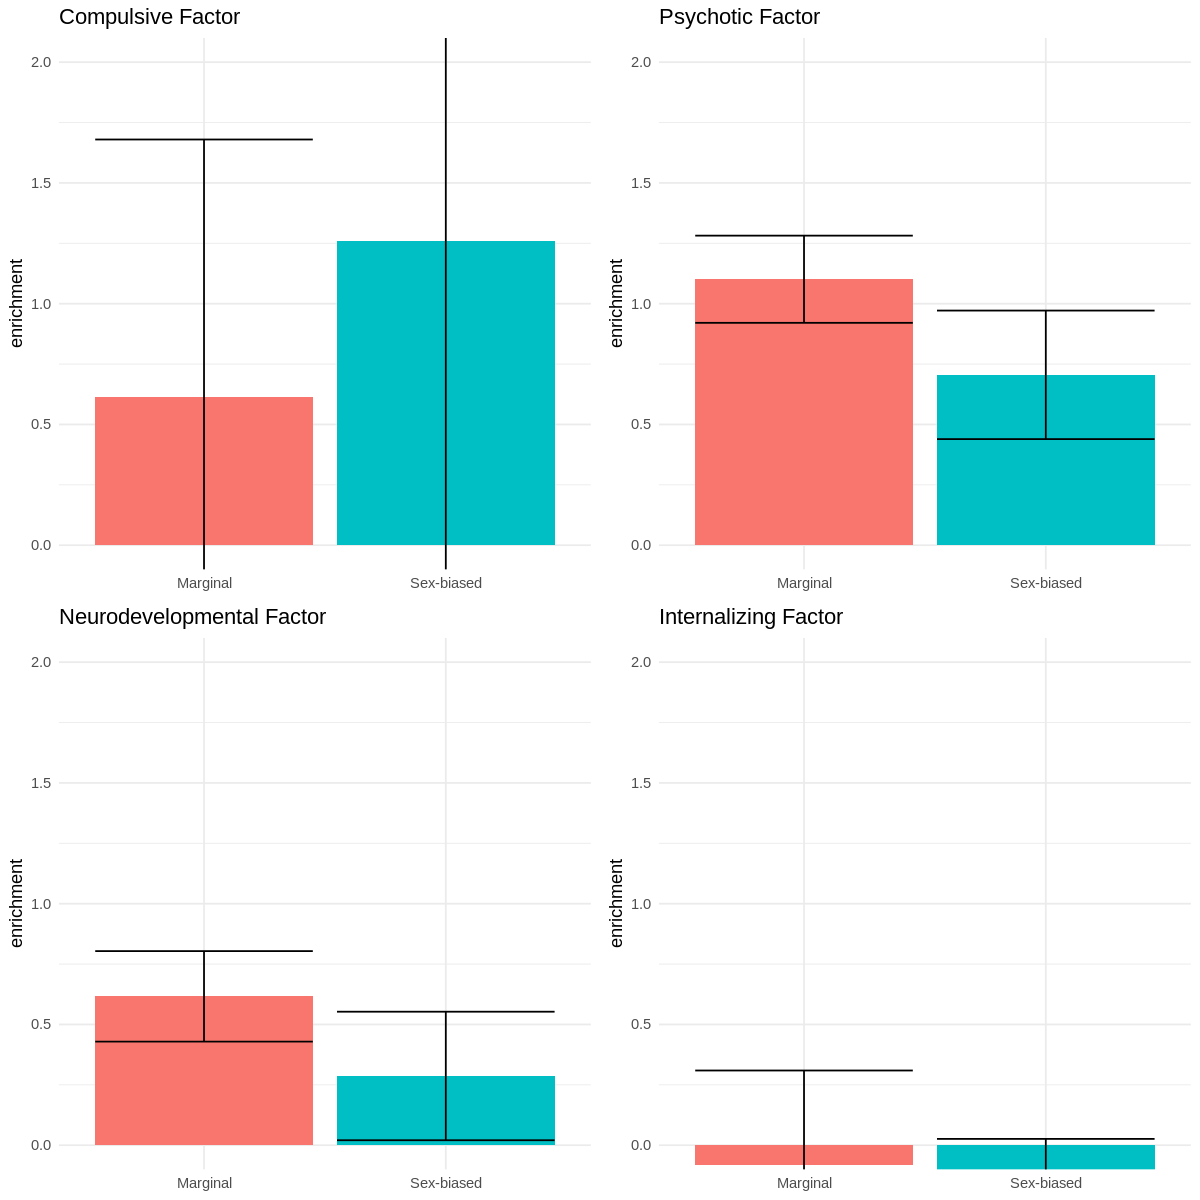

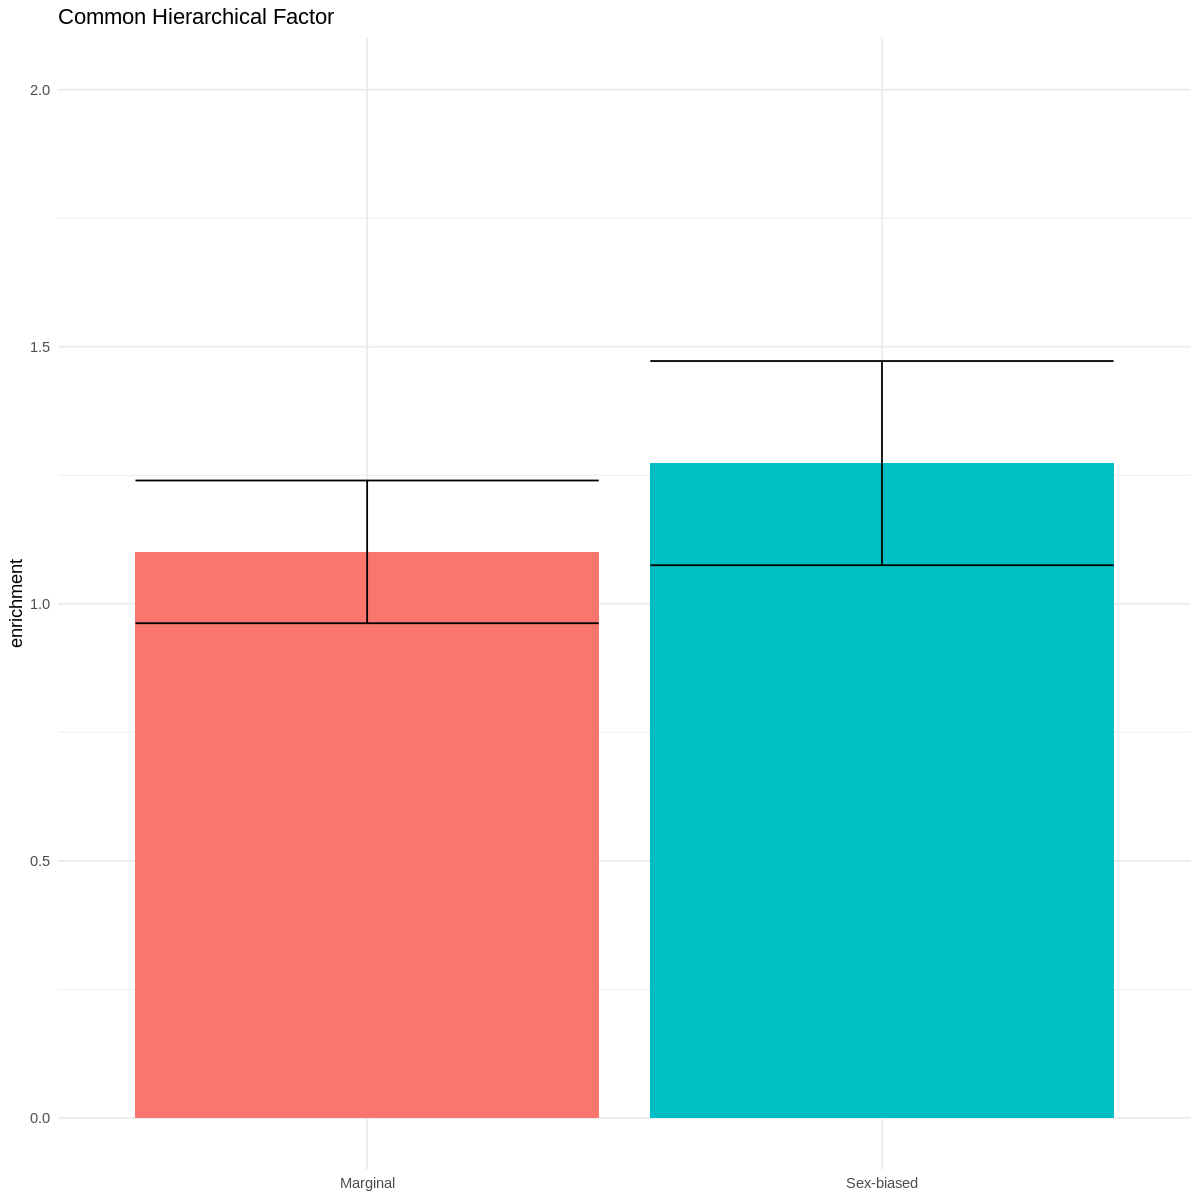

In [10]:
plot_genomicSEM <- function(enrichments,annotation_labels,factor_name,param,annot=52){
    df <- data.frame(
        enrichment= unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment)),
        se = unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment_SE)),
        group= annotation_labels,
        factor = factor_name,
        enrichment_p = unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment_p))
    )
    p <- ggplot(df,aes(x=group,enrichment,fill=group,ymin = enrichment - se, ymax = enrichment + se))+
        geom_col() +
        geom_errorbar() +
        theme_minimal() + 
        guides(fill=F)+
        coord_cartesian(ylim=c(0,2))+
        labs(x=NULL)+
        ggtitle(paste(factor_name))
    return(p)
}
plot_factors <- function(enrich_marginal,enrich_sex_interaction){

    p1 <- plot_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Compulsive Factor",
        1
    )
    p2 <- plot_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Psychotic Factor",
        2
    )
    p3 <- plot_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Neurodevelopmental Factor",
        3
    )
    p4 <- plot_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Internalizing Factor",
        4
    )
    p5 <- plot_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Common Hierarchical Factor",
        5
    )
    print(plot_grid(p1,p2,p3,p4))
    print(p5)
}
options(repr.plot.width=10,repr.plot.height=10)
plot_factors(enrich_marginal, enrich_sex_interaction)
plot_factors(enrich_marginal_anx, enrich_sex_interaction_anx)
                              

In [11]:
df_genomicSEM <- function(enrichments,annotation_labels,factor_name,param,annot=52){
    df <- data.frame(
        enrichment= unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment)),
        se = unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment_SE)),
        group= annotation_labels,
        factor = factor_name,
        enrichment_p = unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment_p))
    )
    return(df)
}
df_factors <- function(enrich_marginal,enrich_sex_interaction){
    df1 <- df_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Compulsive Factor",
        1
    )
    df2 <- df_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Psychotic Factor",
        2
    )
    df3 <- df_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Neurodevelopmental Factor",
        3
    )
    df4 <- df_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Internalizing Factor",
        4
    )
    df5 <- df_genomicSEM(
        list(enrich_marginal,enrich_sex_interaction),
        c("Marginal","Sex-biased"),
        "Common Hierarchical Factor",
        5
    )

    res <- rbind(df1,df2,df3,df4,df5)
    return(res)
}
df_factors(enrich_marginal,enrich_sex_interaction)
df_factors(enrich_marginal_anx,enrich_sex_interaction_anx)

enrichment,se,group,factor,enrichment_p
<dbl>,<dbl>,<chr>,<chr>,<dbl>
0.5496004,1.1290546,Marginal,Compulsive Factor,0.65502298
1.1873474,1.6225823,Sex-biased,Compulsive Factor,0.45403927
1.0991540,0.1721427,Marginal,Psychotic Factor,0.28230790
0.7494886,0.2571613,Sex-biased,Psychotic Factor,0.83500680
0.6424095,0.1895179,Marginal,Neurodevelopmental Factor,0.97040929
0.3838344,0.2676169,Sex-biased,Neurodevelopmental Factor,0.98934415
-0.2115112,0.4005554,Marginal,Internalizing Factor,0.99875510
-1.0328935,0.5769068,Sex-biased,Internalizing Factor,0.99978728
1.1082235,0.1361001,Marginal,Common Hierarchical Factor,0.21325556


enrichment,se,group,factor,enrichment_p
<dbl>,<dbl>,<chr>,<chr>,<dbl>
0.61310149,1.0668543,Marginal,Compulsive Factor,0.64156815
1.25920749,1.5284328,Sex-biased,Compulsive Factor,0.43266615
1.10131413,0.1805028,Marginal,Psychotic Factor,0.28730045
0.70544643,0.2661556,Sex-biased,Psychotic Factor,0.86578754
0.61629718,0.1873335,Marginal,Neurodevelopmental Factor,0.97973146
0.28670009,0.2661141,Sex-biased,Neurodevelopmental Factor,0.99632360
-0.08041483,0.3896821,Marginal,Internalizing Factor,0.99721909
-0.53485561,0.5608946,Sex-biased,Internalizing Factor,0.99689462
1.10098425,0.1388165,Marginal,Common Hierarchical Factor,0.23347028


### Testing enrichment of other annotations for comparison

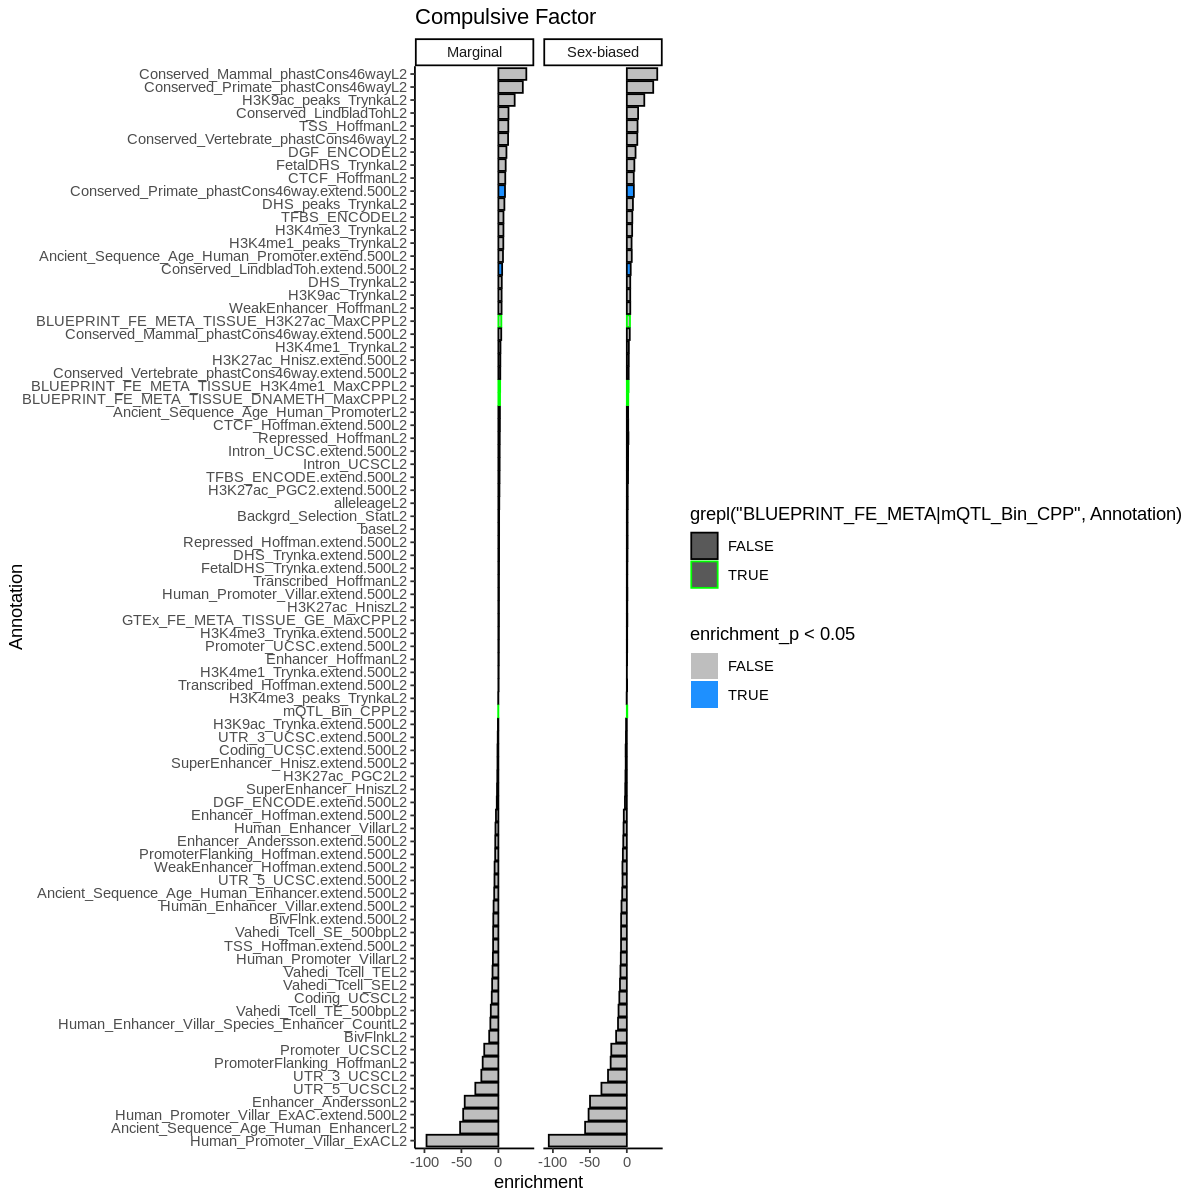

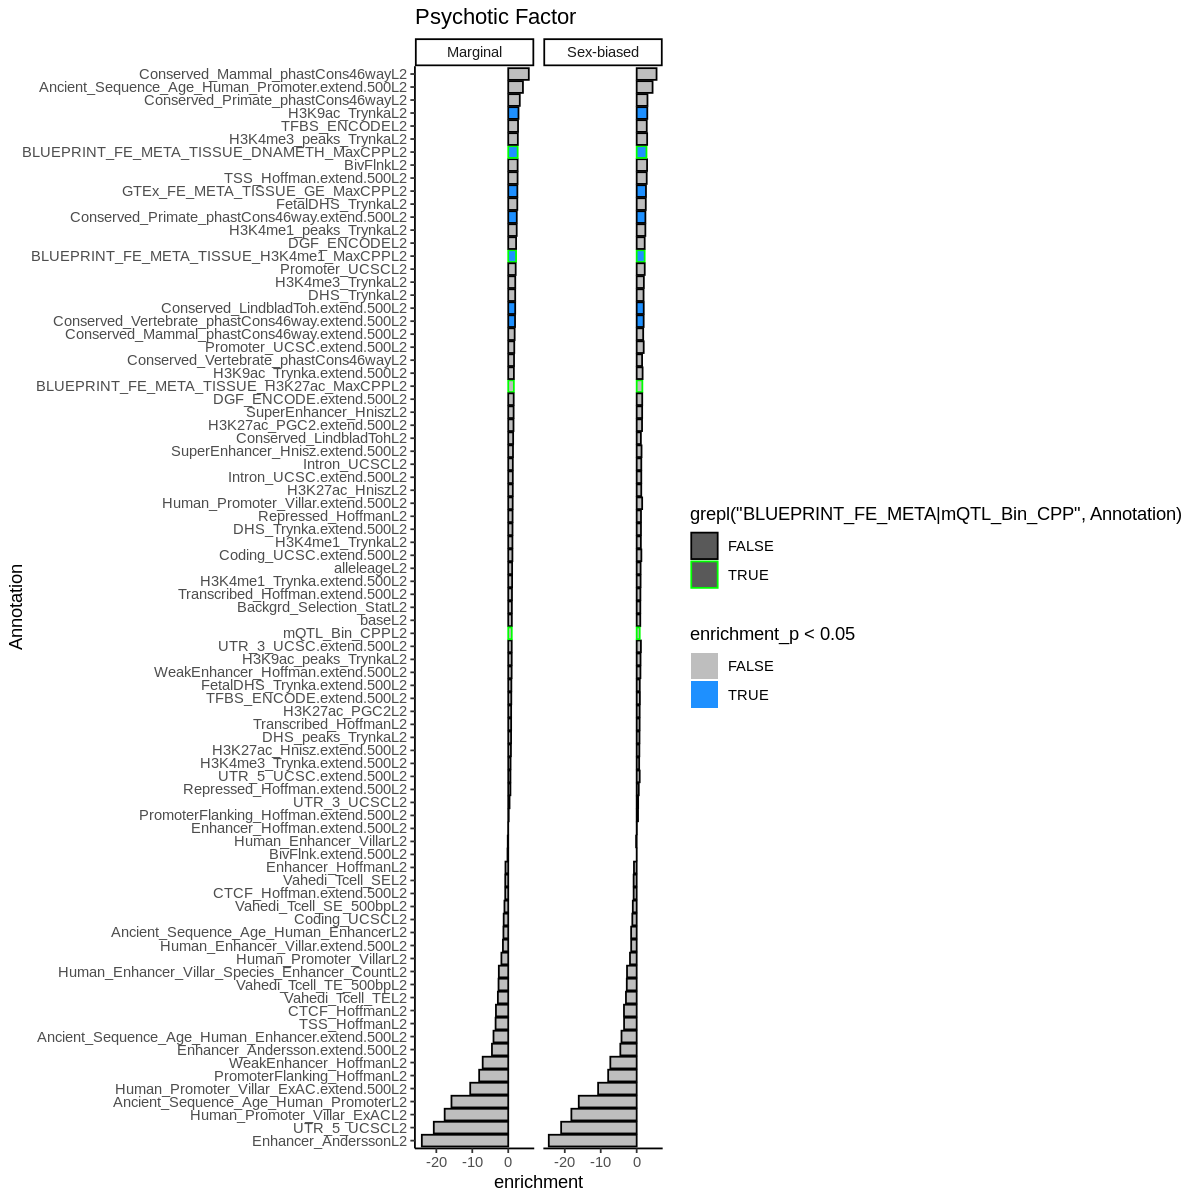

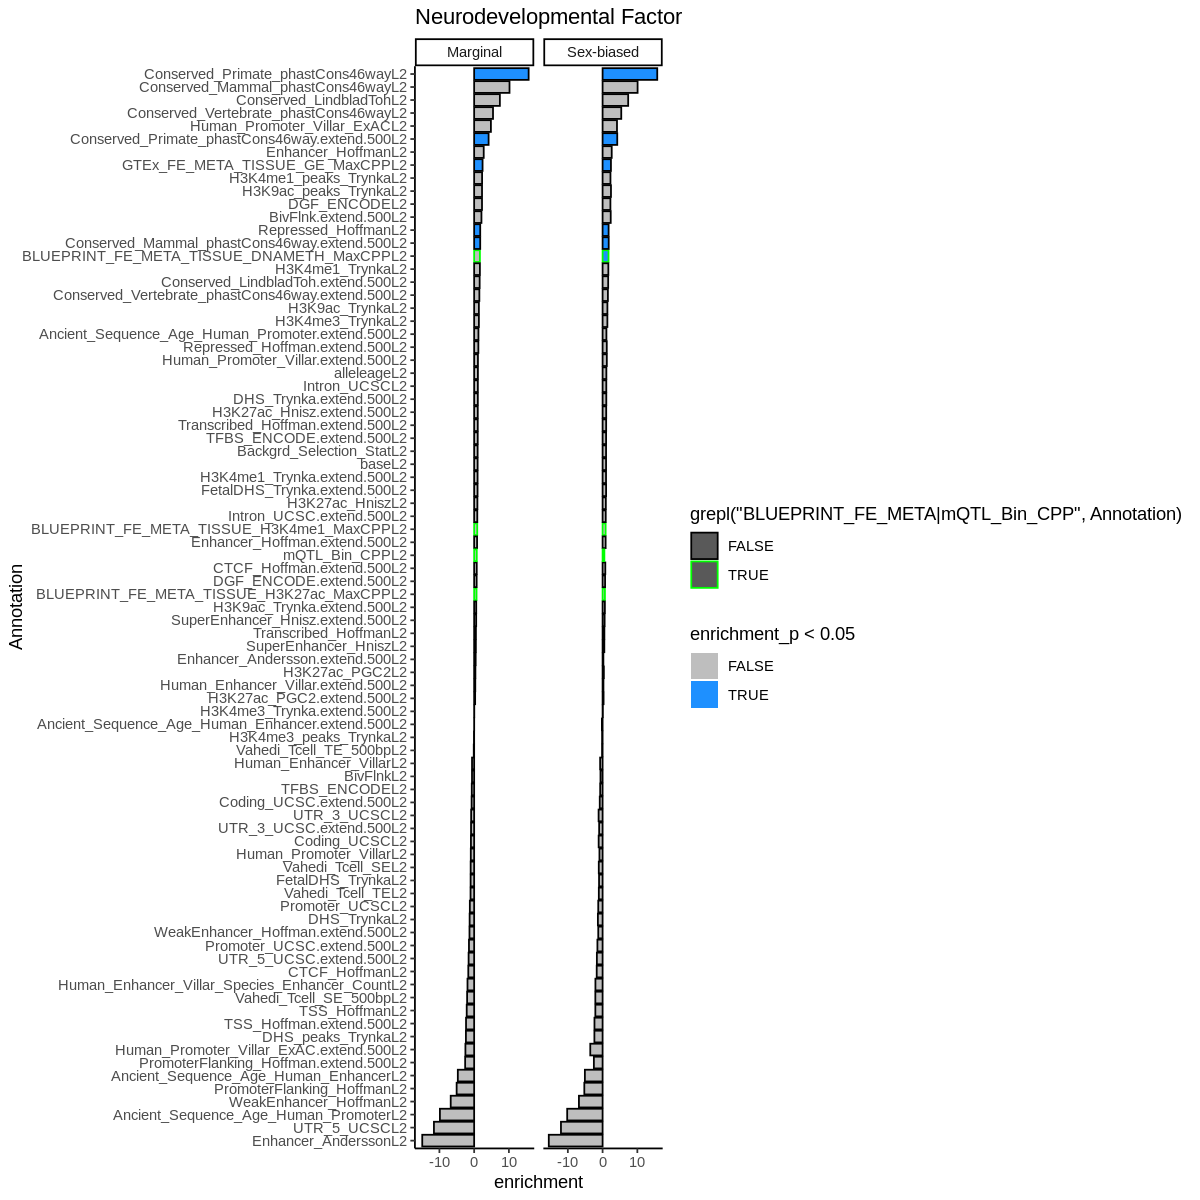

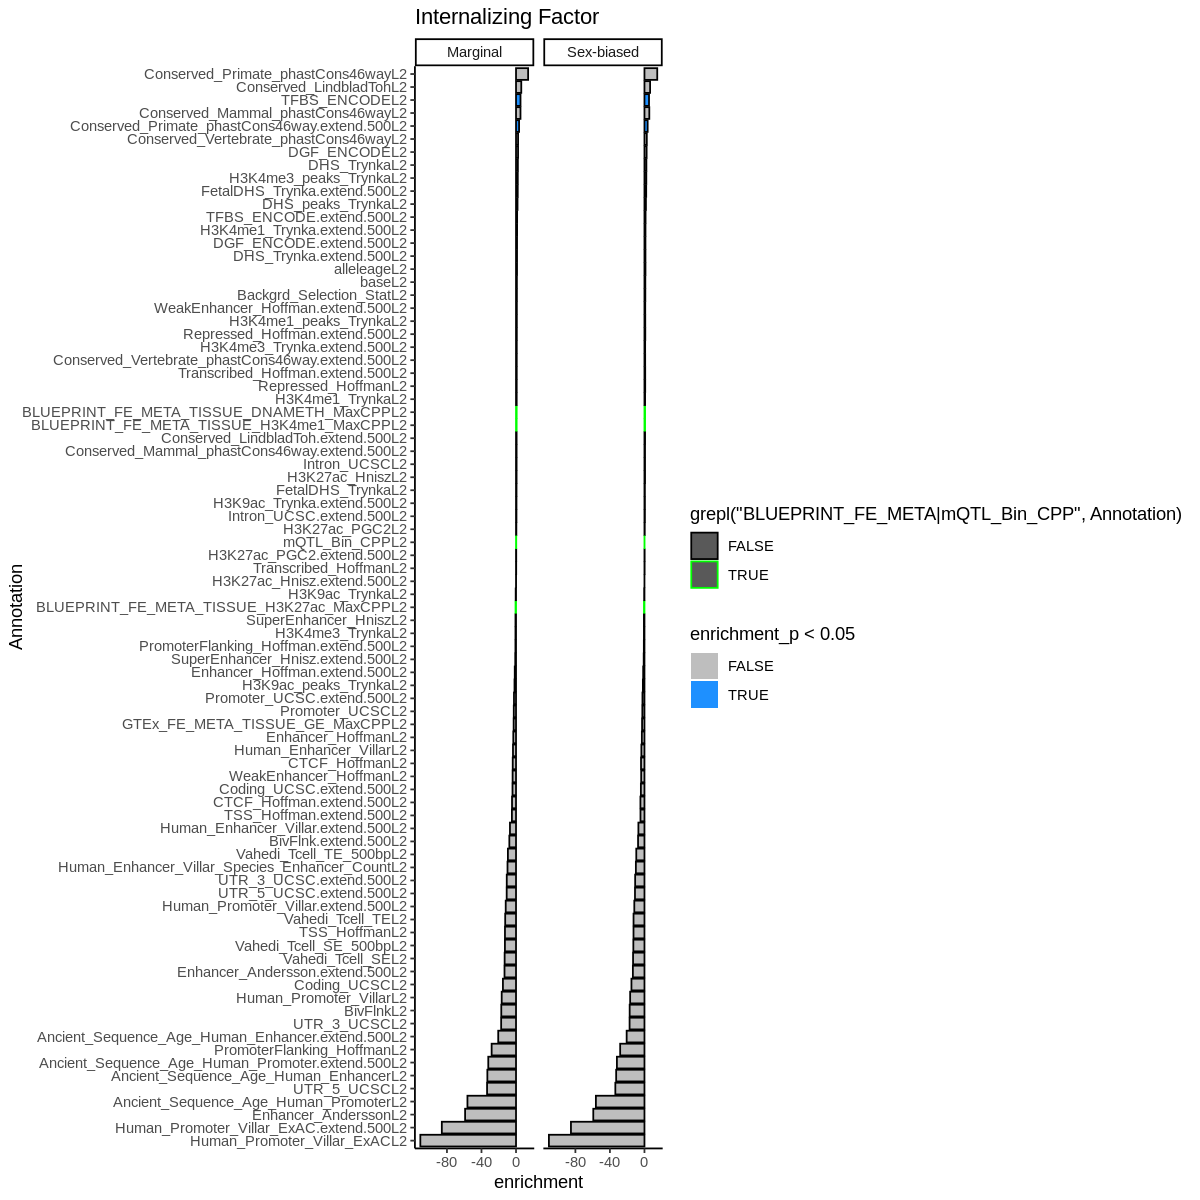

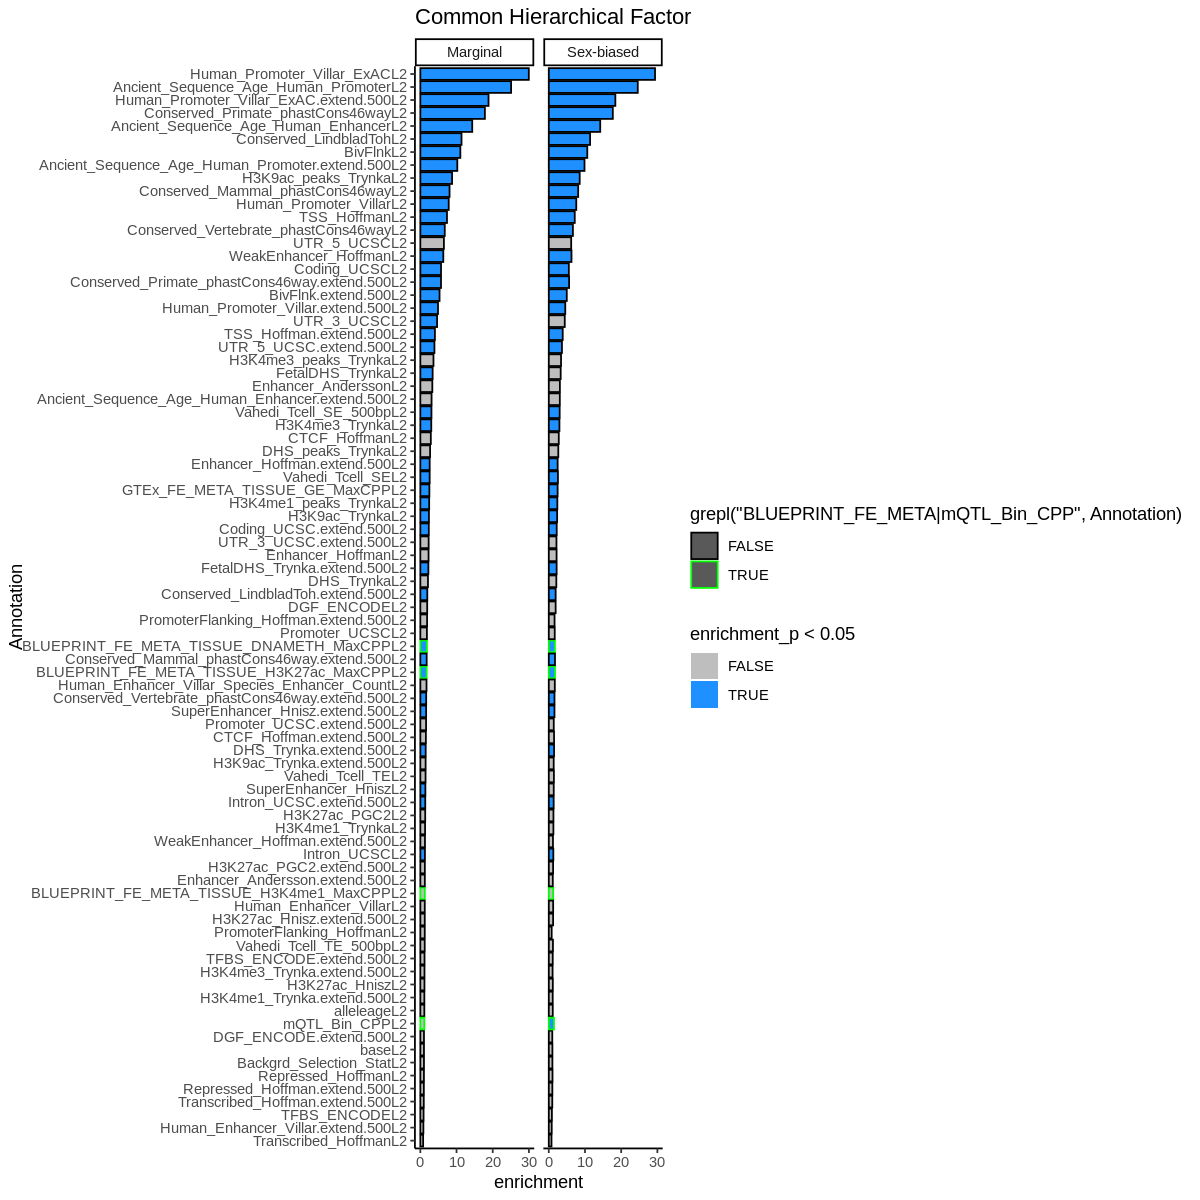

In [40]:
plot_all_coef <- function(param_name, param){
    out <-lapply(
        1:83,
        function(x){ 
           df_genomicSEM(
               list(enrich_marginal_anx,enrich_sex_interaction_anx),
               c("Marginal","Sex-biased"),
               param_name,
               param,
               x
           )
        }
        )
    name_vec <- enrich_marginal[[1]]$Annotation
    name_vec[83] <- "mQTL_Bin_CPPL2"
    names(out) <- name_vec
    to_plot <- rbindlist(out, idcol="Annotation" )
    to_plot$Annotation <- factor(to_plot$Annotation, levels =to_plot[group == "Marginal"][order(enrichment)]$Annotation)
    p <- ggplot(to_plot, aes(Annotation, enrichment, color = grepl("BLUEPRINT_FE_META|mQTL_Bin_CPP",Annotation),fill=enrichment_p < 0.05)) +
        geom_col() +
        facet_wrap(~group)+
        theme_classic() +
        coord_flip() +
        ggtitle(param_name) +
        scale_color_manual(values=c("black","green")) + 
        scale_fill_manual(values=c("gray","dodgerblue"))
    print(p)
}
plot_all_coef("Compulsive Factor", 1)
plot_all_coef("Psychotic Factor", 2)
plot_all_coef("Neurodevelopmental Factor", 3)
plot_all_coef("Internalizing Factor", 4)
plot_all_coef("Common Hierarchical Factor", 5)

In [25]:
base_fit <- usermodel(covstruc = list(LDSCoutput$V,LDSCoutput$S),model = hierarchical_model,std.lv = std.lv)
base_fit_anx <- usermodel(covstruc = list(LDSCoutput$V,LDSCoutput$S),model = hierarchical_model_anx,std.lv = std.lv)

[1] "Running primary model"
[1] "Calculating CFI"
[1] "Calculating Standardized Results"
[1] "Calculating SRMR"
elapsed 
   6.66 
[1] "The S matrix was smoothed prior to model estimation due to a non-positive definite matrix. The largest absolute difference in a cell between the smoothed and non-smoothed matrix was  0.000696950357747115 As a result of the smoothing, the largest Z-statistic change for the genetic covariances was  0.056156668322954 . We recommend setting the smooth_check argument to true if you are going to run a multivariate GWAS."


Warning message in usermodel(covstruc = list(LDSCoutput$V, LDSCoutput$S), model = hierarchical_model, :
“A difference greater than .025 was observed pre- and post-smoothing for Z-statistics in the genetic covariance matrix. This reflects a large difference and results should be interpreted with caution!! This can often result from including low powered traits, and you might consider removing those traits from the model. If you are going to run a multivariate GWAS we strongly recommend setting the smooth_check argument to true to check smoothing for each SNP.”


[1] "Running primary model"
[1] "Calculating CFI"
[1] "Calculating Standardized Results"
[1] "Calculating SRMR"
elapsed 
   8.21 
[1] "The S matrix was smoothed prior to model estimation due to a non-positive definite matrix. The largest absolute difference in a cell between the smoothed and non-smoothed matrix was  0.0012504077801956 As a result of the smoothing, the largest Z-statistic change for the genetic covariances was  0.446368602236582 . We recommend setting the smooth_check argument to true if you are going to run a multivariate GWAS."


Warning message in usermodel(covstruc = list(LDSCoutput$V, LDSCoutput$S), model = hierarchical_model_anx, :
“A difference greater than .025 was observed pre- and post-smoothing for Z-statistics in the genetic covariance matrix. This reflects a large difference and results should be interpreted with caution!! This can often result from including low powered traits, and you might consider removing those traits from the model. If you are going to run a multivariate GWAS we strongly recommend setting the smooth_check argument to true to check smoothing for each SNP.”


In [26]:
library("stringr")
library("lavaan")
library("DiagrammeR")
library("DiagrammeRsvg")
library("dplyr")
library("semPlot")
twelve_traits <- c("AN","OCD","TS","SCZ","BIP","ALC","ADHD","ASD","PTSD","MDD","ANXFS")
node_list <- c(twelve_traits,"F1","F2","F3","F4","P")
fit <- base_fit$results
# What's missing? Covariance/variance (~~) and intercept (~1) paths
edges <- create_edge_df(label = round(fit$STD_All,4),to=sapply(fit$rhs,function(i) which(i == node_list)),from=sapply(fit$lhs,function(i) which(i == node_list)))
nodes <- create_node_df(n=length(node_list),label = node_list,type=c(rep("a",11),rep("b",5)),shape= c(rep("square",11),rep("circle",5)))
# Combine edges and nodes
unique(fit$rhs)
my_graph <- create_graph(
  edges_df = edges,
  nodes_df = nodes,
 attr_theme="tb"
)

# We can save the graph to a fileb
export_graph(my_graph,file_type="svg",file_name="meta_hierarchical_graph_fit.svg")
                                                                                                                      
twelve_traits <- c("AN","OCD","TS","SCZ","BIP","ALC","ADHD","ASD","PTSD","MDD","ANX")
node_list <- c(twelve_traits,"F1","F2","F3","F4","P")
fit <- base_fit_anx$results
# What's missing? Covariance/variance (~~) and intercept (~1) paths
edges <- create_edge_df(label = round(fit$STD_All,4),to=sapply(fit$rhs,function(i) which(i == node_list)),from=sapply(fit$lhs,function(i) which(i == node_list)))
nodes <- create_node_df(n=length(node_list),label = node_list,type=c(rep("a",11),rep("b",5)),shape= c(rep("square",11),rep("circle",5)))
# Combine edges and nodes
unique(fit$rhs)
my_graph <- create_graph(
  edges_df = edges,
  nodes_df = nodes,
 attr_theme="tb"
)

# We can save the graph to a fileb
export_graph(my_graph,file_type="svg",file_name="meta_hierarchical_graph_fit_anx.svg")

[1] "F1"    "F2"    "F3"    "F4"    "AN"    "OCD"   "TS"    "SCZ"   "BIP"  
[10] "ALC"   "ADHD"  "ASD"   "PTSD"  "MDD"   "ANXFS" "P"

[1] "F1"   "F2"   "F3"   "F4"   "AN"   "OCD"  "TS"   "SCZ"  "BIP"  "ALC" 
[11] "ADHD" "ASD"  "PTSD" "MDD"  "ANX"  "P"

![figure](meta_hierarchical_graph_fit.svg)
![figure](meta_hierarchical_graph_fit_anx.svg)

## Testing other mQTL annotations via stratified genomic SEM

* male specific
* female specific
* maxCPP annotations

### Utilities

In [13]:
hierarchical_model <- "P=~F1+F2+F3+F4
F1=~AN+OCD+TS
F2=~SCZ+BIP+ALC
F3=~TS+ALC+ADHD+ASD+PTSD+MDD
F4=~ALC+PTSD+MDD+ANX
F1~~F1
F2~~F2
F3~~F3
F4~~F4
AN~~a*AN
a > 0.01
OCD~~b*OCD
b > 0.01
TS~~c*TS
c > 0.01
SCZ~~d*SCZ
d > 0.01
BIP~~e*BIP
e > 0.01
ALC~~f*ALC
f > 0.01
ADHD~~g*ADHD
g > 0.01
ASD~~h*ASD
h > 0.01
PTSD~~i*PTSD
i > 0.01
MDD~~j*MDD
j > 0.01
ANX~~k*ANX
k > 0.01
"
df_genomicSEM <- function(enrichments,annotation_labels,factor_name,param,annot=52){
    df <- data.frame(
        enrichment= unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment)),
        se = unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment_SE)),
        group= annotation_labels,
        factor = factor_name,
        enrichment_p = unlist(sapply(enrichments, function(struct) struct[[param]][annot,]$Enrichment_p))
    )
    return(df)
}
params <- c("F1~~F1","F2~~F2","F3~~F3","F4~~F4","P~~P")
std.lv <- TRUE
df_enrich_from_struct <- function(s_covstruc,annotation_label,param_name,param){
    enrich_struct <- enrich(s_covstruc = s_covstruc,model = hierarchical_model,params=params,std.lv = std.lv)
    out <- mclapply(
        1:52,
        function(x){ 
           df_genomicSEM(
               list(enrich_struct),
               annotation_label,
               param_name,
               param,
               x
           )
        },
        mc.cores = round(detectCores() / 2)
    )
    name_vec <- enrich_struct[[1]]$Annotation
    name_vec[52] <- annotation_label
    names(out) <- name_vec
    to_plot <- rbindlist(out, idcol="Annotation" )
    to_plot$Annotation <- factor(to_plot$Annotation, levels =to_plot[group == group[1]][order(enrichment)]$Annotation)                              
    return(to_plot)
}

### Male_specific

In [15]:
category<- c("Compulsive Factor", "Psychotic Factor", "Neurodevelopmental Factor", "Internalizing Factor", "Common Hierarchical Factor")
if(file.exists("male_enrich_bin_CPP_her.RDS")){
    male_enrich_bin_CPP <- readRDS("male_enrich_bin_CPP_her.RDS")
}else{
    male_bin_CPP_struct <- readRDS("../data/SLDSCoutput_male_bin_CPP_her.RDS")
    male_enrich_bin_CPP <- mclapply(
        1:length(category),
        function(i) df_enrich_from_struct(male_bin_CPP_struct,"male_bin_CPP_her",category[i],i),
        mc.cores = length(category)
    )
    saveRDS(male_enrich_bin_CPP, "male_enrich_bin_CPP_her.RDS")
}
# if(file.exists("male_specific_enrich_bin_CPP.RDS")){
#     male_specific_enrich_bin_CPP <- readRDS("male_specific_enrich_bin_CPP.RDS")
# }else{
#     male_specific_bin_CPP_struct <- readRDS("../data/SLDSCoutput_male_specific_meta_bin_CPP.RDS")
#     male_specific_enrich_bin_CPP <- mclapply(
#         1:length(category),
#         function(i) df_enrich_from_struct(male_specific_bin_CPP_struct,"male_bin_CPP",category[i],i),
#         mc.cores = length(category)
#     )
#     saveRDS(male_specific_enrich_bin_CPP, "male_specific_enrich_bin_CPP.RDS")
# }

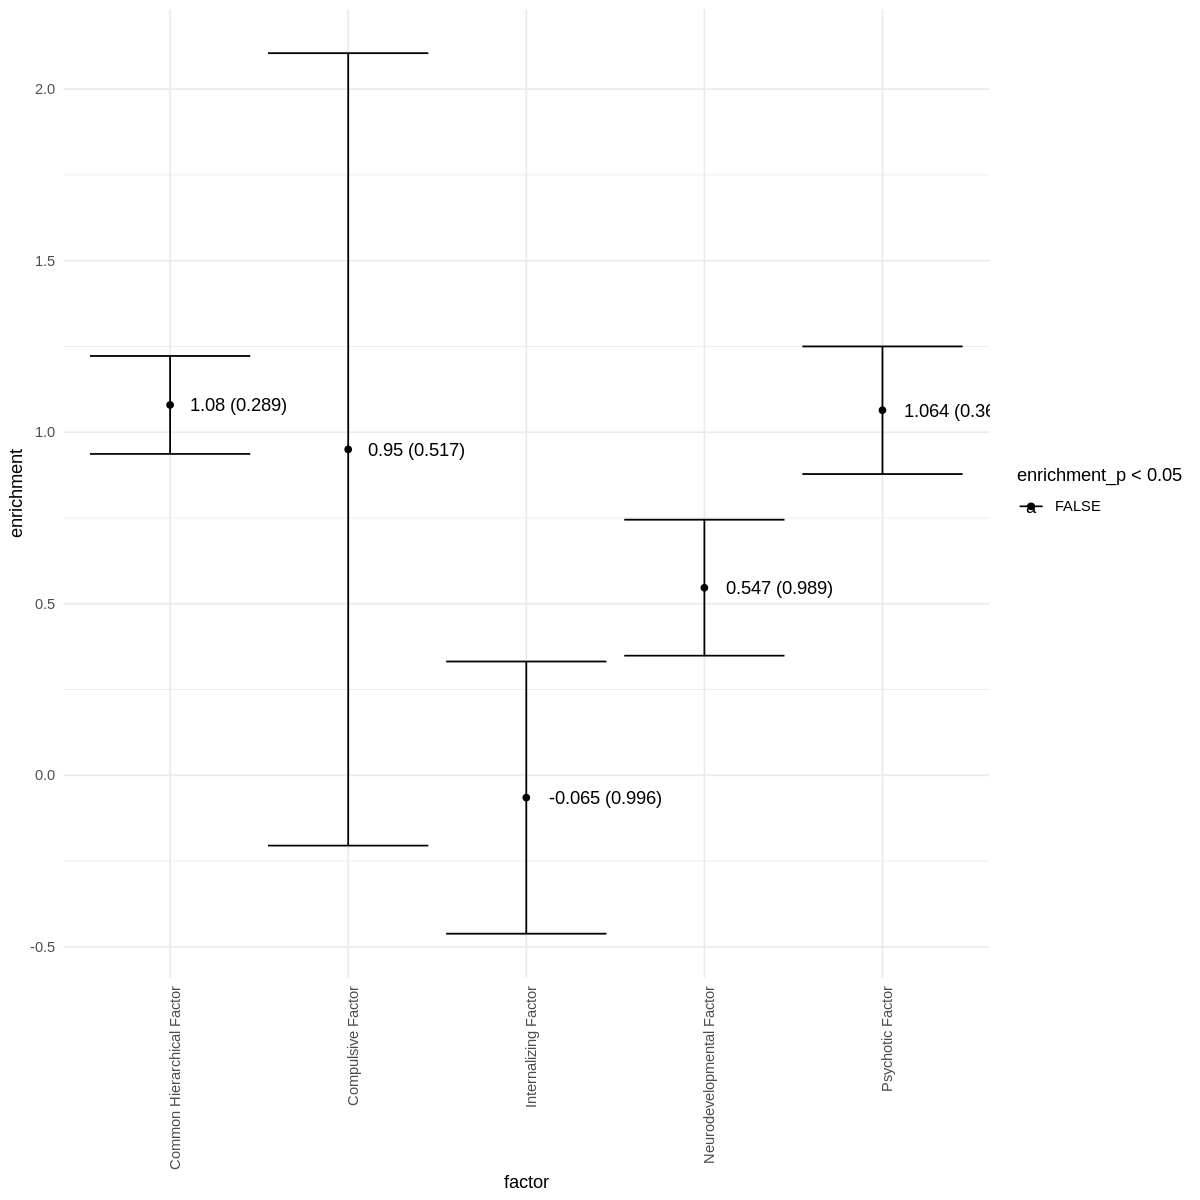

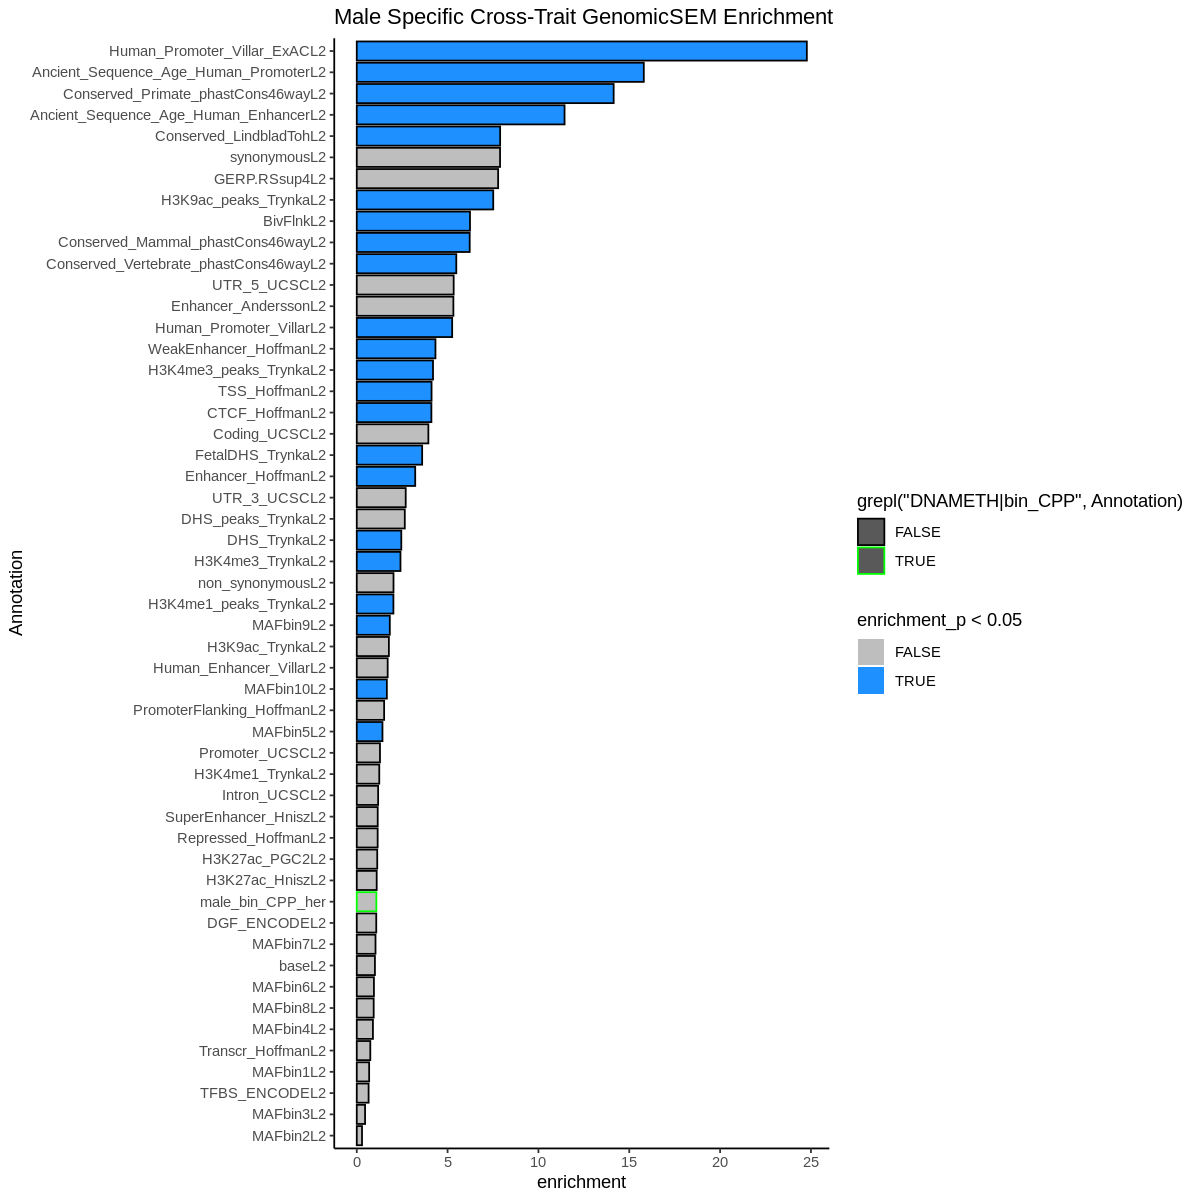

In [16]:
rbindlist(male_enrich_bin_CPP) %>% 
    filter(Annotation == group) %>%
        ggplot(
            aes(
                factor,
                enrichment,
                ymin=enrichment - se,
                ymax = enrichment +se,
                color = enrichment_p < 0.05,
                label = glue("{round(enrichment,3)} ({round(enrichment_p,3)})")
            )
        )+ 
            geom_text(hjust=-.2)+
            geom_point() +
            geom_errorbar()+
            scale_color_manual(values= c("black","red"))+
            theme_minimal()+
            theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1))
# rbindlist(male_specific_enrich_bin_CPP) %>% 
#     filter(Annotation == group) %>%
#         ggplot(
#             aes(
#                 factor,
#                 enrichment,
#                 ymin=enrichment - se,
#                 ymax = enrichment +se,
#                 color = enrichment_p < 0.05,
#                 label = glue("{round(enrichment,3)} ({round(enrichment_p,3)})")
#             )
#         )+ 
#             geom_text(hjust=-.2)+
#             geom_point() +
#             geom_errorbar()+
#             ggtitle("Male Specific Cross-Trait GenomicSEM Enrichment")+
#             scale_color_manual(values= c("black","red"))+
#             theme_minimal()+
#             theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1),plot.title = element_text(size = 30))
male_enrich_bin_CPP[[5]] %>% mutate(Annotation=fct_reorder(Annotation, enrichment)) %>%
    ggplot(aes(Annotation, enrichment, color = grepl("DNAMETH|bin_CPP",Annotation),fill=enrichment_p < 0.05)) +
        geom_col() +
        theme_classic() +
        coord_flip() +
        ggtitle("Male Specific Cross-Trait GenomicSEM Enrichment")+
        scale_color_manual(values=c("black","green")) + 
        scale_fill_manual(values=c("gray","dodgerblue"))

### Female Specific

In [17]:
category<- c("Compulsive Factor", "Psychotic Factor", "Neurodevelopmental Factor", "Internalizing Factor", "Common Hierarchical Factor")
if(file.exists("female_enrich_bin_CPP_her.RDS")){
    female_enrich_bin_CPP <- readRDS("female_enrich_bin_CPP_her.RDS")
}else{
    female_bin_CPP_struct <- readRDS("../data/SLDSCoutput_female_bin_CPP_her.RDS")
    female_enrich_bin_CPP <- mclapply(
        1:length(category),
        function(i) df_enrich_from_struct(female_bin_CPP_struct,"female_bin_CPP_her",category[i],i),
        mc.cores = length(category)
    )
    saveRDS(female_enrich_bin_CPP, "female_enrich_bin_CPP_her.RDS")
}
# if(file.exists("female_specific_enrich_bin_CPP.RDS")){
#     female_specific_enrich_bin_CPP <- readRDS("female_specific_enrich_bin_CPP.RDS")
# }else{
#     female_specific_bin_CPP_struct <- readRDS("../data/SLDSCoutput_female_specific_meta_bin_CPP.RDS")
#     female_specific_enrich_bin_CPP <- mclapply(
#         1:length(category),
#         function(i) df_enrich_from_struct(female_specific_bin_CPP_struct,"female_bin_CPP",category[i],i),
#         mc.cores = length(category)
#     )
#     saveRDS(female_specific_enrich_bin_CPP, "female_specific_enrich_bin_CPP.RDS")
# }

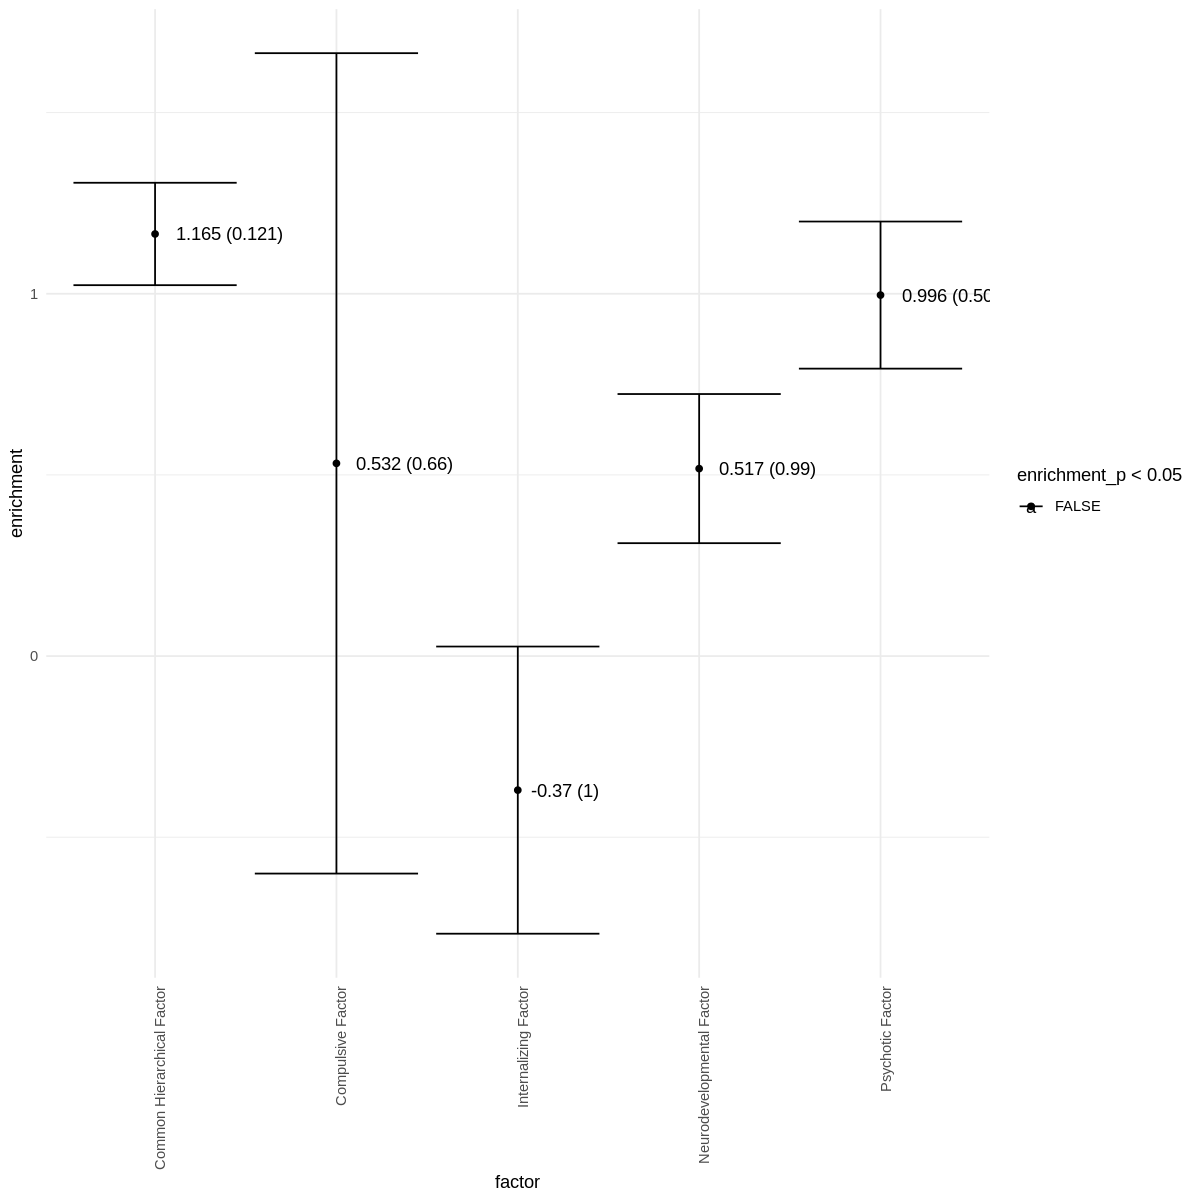

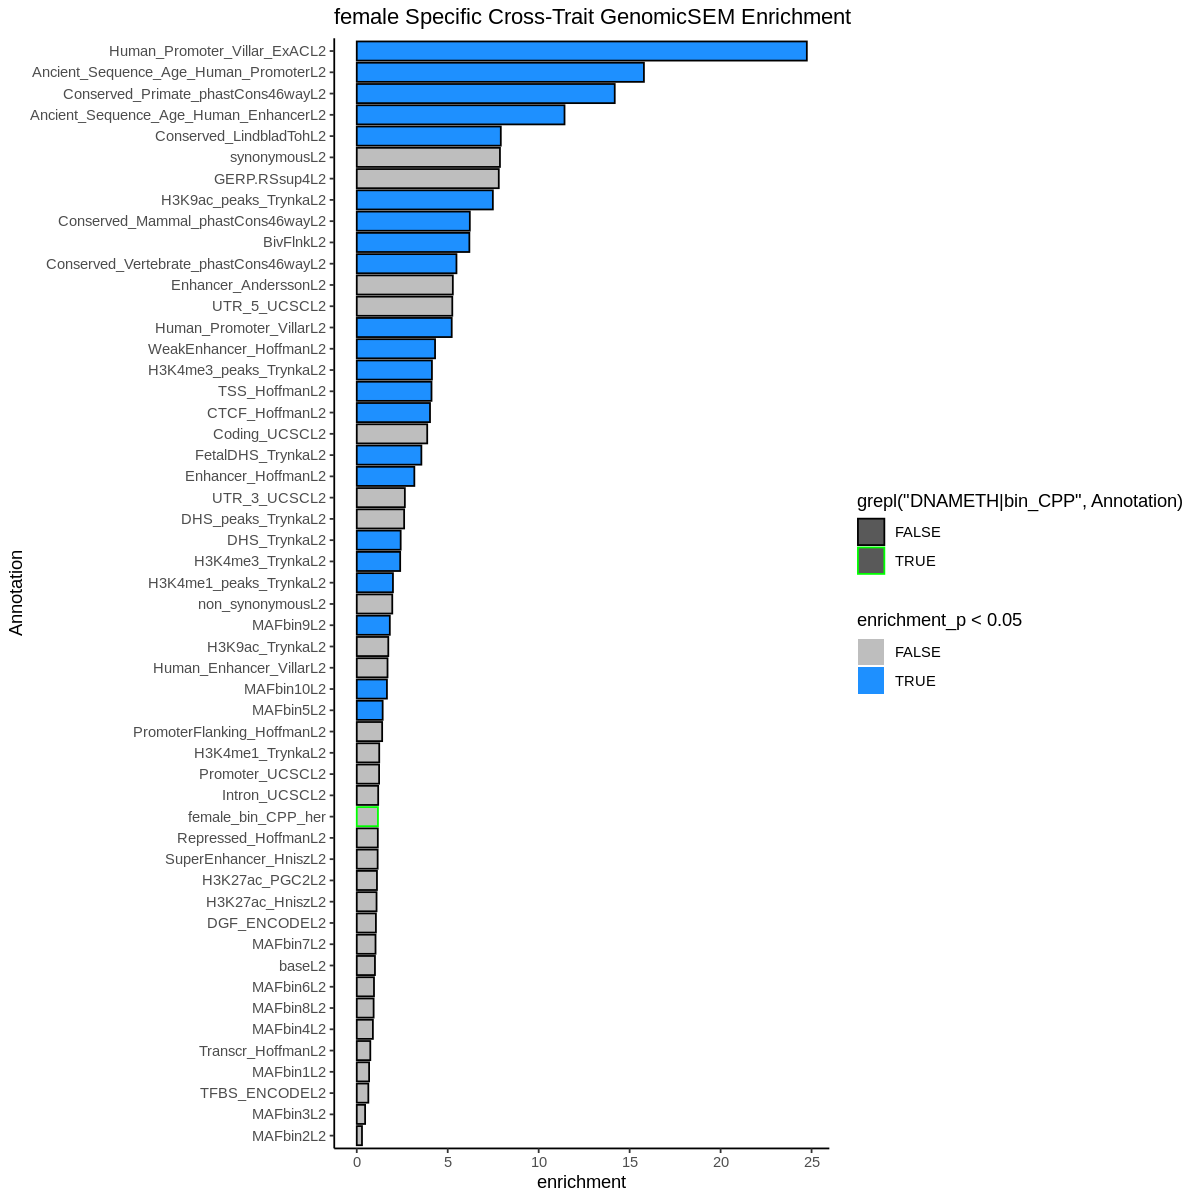

In [18]:
rbindlist(female_enrich_bin_CPP) %>% 
    filter(Annotation == group) %>%
        ggplot(
            aes(
                factor,
                enrichment,
                ymin=enrichment - se,
                ymax = enrichment +se,
                color = enrichment_p < 0.05,
                label = glue("{round(enrichment,3)} ({round(enrichment_p,3)})")
            )
        )+ 
            geom_text(hjust=-.2)+
            geom_point() +
            geom_errorbar()+
            scale_color_manual(values= c("black","red"))+
            theme_minimal()+
            theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1))
# rbindlist(female_specific_enrich_bin_CPP) %>% 
#     filter(Annotation == group) %>%
#         ggplot(
#             aes(
#                 factor,
#                 enrichment,
#                 ymin=enrichment - se,
#                 ymax = enrichment +se,
#                 color = enrichment_p < 0.05,
#                 label = glue("{round(enrichment,3)} ({round(enrichment_p,3)})")
#             )
#         )+ 
#             geom_text(hjust=-.2)+
#             geom_point() +
#             geom_errorbar()+
#             ggtitle("female Specific Cross-Trait GenomicSEM Enrichment")+
#             scale_color_manual(values= c("black","red"))+
#             theme_minimal()+
#             theme(axis.text.x=element_text(angle=90,hjust=1,vjust=1),plot.title = element_text(size = 30))
female_enrich_bin_CPP[[5]] %>% mutate(Annotation=fct_reorder(Annotation, enrichment)) %>%
    ggplot(aes(Annotation, enrichment, color = grepl("DNAMETH|bin_CPP",Annotation),fill=enrichment_p < 0.05)) +
        geom_col() +
        theme_classic() +
        coord_flip() +
        ggtitle("female Specific Cross-Trait GenomicSEM Enrichment")+
        scale_color_manual(values=c("black","green")) + 
        scale_fill_manual(values=c("gray","dodgerblue"))